In [47]:
# Eklenecek import ifadeleri
import numpy as np
from scipy.optimize import curve_fit
import os
import time
from datetime import time as dt_time, datetime, timedelta
import random
import copy
import heapq
from typing import List, Dict, Tuple, Set, Optional
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Klasörleri oluştur
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [48]:
class Drone:
    def __init__(self,id:int,max_weight:float,battery:int,speed:float,start_pos:Tuple[float,float]):
        self.current_delivery_id = None  # Current active delivery
        self.id=id
        self.max_weight=max_weight
        self.battery = battery
        self.speed=speed
        self.start_pos=start_pos
        #Durum Bilgileri:
        self.current_pos=start_pos
        self.remaining_battery=battery
        self.carrying_weight=0.0
        self.assigned_deliveries=[] #Teslimat ID'leri
        self.charging = False
        self.charge_time_remaining = 0  # şarjın tamamlanmasına kalan süre
        self.charge_count = 0  # toplam şarj sayısı
        self.total_charge_time = 0  # toplam şarj süresi
        self.total_energy_consumed = 0  # toplam enerji tüketimi

    def go_to_charge(self):
        """
        Drone'u şarj moduna geçirir.
        Şarj süresi batarya seviyesine göre dinamik hesaplanır.
        """
        # Eğer zaten şarj oluyorsa tekrar başlatma
        if self.charging:
            return

        self.charging = True
        self.charge_count += 1

        # Dinamik şarj süresi hesaplama - PDF'deki gereksinimlere göre
        remaining_percentage = self.remaining_battery / self.battery
        needed_charge = 1.0 - remaining_percentage

        # Şarj süresi: tam şarj için 60 dakika, kalan şarj oranına göre hesaplanır
        self.charge_time_remaining = int(needed_charge * 60)
        self.total_charge_time += self.charge_time_remaining

        print(f"Drone {self.id} şarja gidiyor. Şarj süresi: {self.charge_time_remaining} dakika (Kalan batarya: {remaining_percentage*100:.1f}%)")

        # Şarj istasyonuna dönüş (varsayılan olarak başlangıç konumuna)
        self.current_pos = self.start_pos

    def update(self, time_passed: float):
        """
        time_passed: geçen süre (örneğin dakika cinsinden)
        Bu fonksiyon drone durumunu günceller:
        - Eğer şarj oluyorsa, kalan şarj süresini azaltır.
        - Şarj tamamlandıysa, bataryayı full yapar.
        - Uçuyorsa, batarya tüketimini azaltır.
        """
        # Dinamik batarya tüketim oranı - ağırlık ve hıza bağlı
        # PDF'deki batarya tüketim modeline göre
        base_consumption_rate = 10  # Birim zamanda temel batarya tüketim oranı
        weight_factor = 1.0 + (self.carrying_weight / self.max_weight) * 2.0  # Ağırlık faktörü
        speed_factor = 1.0 + (self.speed / 15.0)  # Hız faktörü

        # Dinamik eşik - yük ve hıza göre
        threshold = 500 * (1 + (self.carrying_weight / self.max_weight) * 0.5)

        # Tüketim oranı hesaplama
        consumption_rate = base_consumption_rate * weight_factor * speed_factor

        if self.charging:
            self.charge_time_remaining -= time_passed
            if self.charge_time_remaining <= 0:
                self.charging = False
                old_battery = self.remaining_battery
                self.remaining_battery = self.battery
                print(f"Drone {self.id} şarj tamamlandı. Batarya: {old_battery:.1f} → {self.remaining_battery:.1f}")
        else:
            # Uçuş ve batarya tüketimi simülasyonu
            energy_consumed = consumption_rate * time_passed
            self.remaining_battery -= energy_consumed
            self.total_energy_consumed += energy_consumed

            # Kritik batarya kontrolü
            if self.remaining_battery < threshold and not self.charging:
                print(f"Drone {self.id} kritik batarya seviyesinde ({self.remaining_battery:.1f}/{self.battery}), şarja gidiyor...")
                self.go_to_charge()

    def consume_battery_for_delivery(self, distance: float, weight: float) -> bool:
        """
        Belirli bir teslimat için batarya tüketimi

        Returns:
            bool: Yeterli batarya varsa True, yoksa False
        """
        energy_needed = Utils.calculate_battery_consumption(distance, weight, self.speed)

        # Batarya kontrolü
        if energy_needed > self.remaining_battery:
            print(f"Drone {self.id} için batarya yetersiz: {self.remaining_battery:.1f} < {energy_needed:.1f}")
            return False

        # Batarya tüket
        self.remaining_battery -= energy_needed
        self.total_energy_consumed += energy_needed
        print(f"Drone {self.id} teslimat için {energy_needed:.1f} enerji tüketti. Kalan: {self.remaining_battery:.1f}")
        return True

    def __repr__(self):
        return (f"Drone(id={self.id}, max_weight={self.max_weight}, battery={self.battery}, speed={self.speed}, "
                f"pos={self.current_pos}, remaining_battery={self.remaining_battery:.1f}, charging={self.charging})")

class DeliveryPoint:
    def __init__(self,id:int,pos:Tuple[float,float],weight:float,priority:int,time_window:Tuple[time,time]):
        self.id=id
        self.pos=pos
        self.weight=weight
        self.priority=priority
        self.time_window=time_window # (start_time, end_time)

    def __repr__(self):
        return f"Delivery(id={self.id}, pos={self.pos}, weight={self.weight}, priority={self.priority})"

class NoFlyZone:
    def __init__(self,id:int,coordinates:Tuple[float,float],active_time:Tuple[time,time]):
        self.id=id
        self.coordinates=coordinates  # [(x1, y1), (x2, y2), ...]
        self.active_time=active_time  # (start_time, end_time)

    def __repr__(self):
        return f"NoFlyZone(id={self.id}, active={self.active_time})"

In [49]:
import random
from datetime import time as dt_time
import os

def generate_random_time_window(start_hour_range=(9,12),duration_range=(30,90)):
    start_hour=random.randint(*start_hour_range)
    start_minute=random.randint(0,59)
    start=dt_time(start_hour,start_minute)  # time modülü yerine dt_time kullan
    duration_minutes=random.randint(*duration_range)
    end_hour=(start_hour+(start_minute+duration_minutes)//60) %24
    end_minute=(start_minute+duration_minutes)%60
    end=dt_time(end_hour,end_minute)  # time modülü yerine dt_time kullan
    return (start,end)

def generate_drones(n):
    drones=[]
    for i in range(n):
        drone={
            "id":i,
            "max_weight":round(random.uniform(2.0,5.0),2),
            "battery":random.randint(5000,10000),
            "speed": round(random.uniform(5.0, 15.0), 2),
            "start_pos": (random.randint(0, 100), random.randint(0, 100))
        }
        drones.append(drone)
    return drones

def generate_deliveries(n):
    deliveries=[]
    for i in range(n):
        delivery={
            "id":i,
            "pos":(random.randint(0,200),random.randint(0,200)),
            "weight": round(random.uniform(0.5,3.0),2),
            "priority":random.randint(1,5),
            "time_window":generate_random_time_window()
        }
        deliveries.append(delivery)
    return deliveries

def generate_no_fly_zones(n):
    zones=[]
    for i in range(n):
        x, y = random.randint(50, 150), random.randint(50, 150)
        zone={
            "id":i,
            "coordinates" : [(x, y), (x+10, y), (x+10, y+10), (x, y+10)],
            "active_time":generate_random_time_window()
        }
        zones.append(zone)
    return zones

def save_dataset_to_txt(drones, deliveries, zones, file_path="data/dataset.txt"):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with open(file_path, "w") as f:
        f.write("[DRONES]\n")
        for d in drones:
            f.write(f"{d['id']},{d['max_weight']},{d['battery']},{d['speed']},{d['start_pos'][0]},{d['start_pos'][1]}\n")

        f.write("\n[DELIVERIES]\n")
        for dp in deliveries:
            f.write(f"{dp['id']},{dp['pos'][0]},{dp['pos'][1]},{dp['weight']},{dp['priority']},{dp['time_window'][0].strftime('%H:%M')},{dp['time_window'][1].strftime('%H:%M')}\n")

        f.write("\n[NO_FLY_ZONES]\n")
        for z in zones:
            coords_str = ";".join(f"{x}:{y}" for x, y in z['coordinates'])
            f.write(f"{z['id']},{coords_str},{z['active_time'][0].strftime('%H:%M')},{z['active_time'][1].strftime('%H:%M')}\n")

In [50]:
import os
from datetime import time as dt_time

def parse_time(timestr):
    """'HH:MM' biçimindeki string'i time nesnesine çevirir."""
    hour,minute = map(int,timestr.strip().split(":"))
    return dt_time(hour,minute)

def load_dataset(file_path="data/dataset.txt"):
    drones=[]
    deliveries=[]
    no_fly_zones=[]

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} bulunamadı")

    section=None
    with open(file_path,"r") as f:
        for line in f:
            line=line.strip()
            if not line or line.startswith("#"):
                continue
            if line=="[DRONES]":
                section="DRONES"
                continue
            elif line=="[DELIVERIES]":
                section="DELIVERIES"
                continue
            elif line=="[NO_FLY_ZONES]":
                section="NO_FLY_ZONES"
                continue

            if section =="DRONES":
                parts=line.split(",")
                d = Drone(
                    id=int(parts[0]),
                    max_weight=float(parts[1]),
                    battery=int(parts[2]),
                    speed=float(parts[3]),
                    start_pos=(int(parts[4]), int(parts[5]))
                )
                drones.append(d)
            elif section == "DELIVERIES":
                parts = line.split(",")
                dp = DeliveryPoint(
                    id=int(parts[0]),
                    pos=(int(parts[1]), int(parts[2])),
                    weight=float(parts[3]),
                    priority=int(parts[4]),
                    time_window=(parse_time(parts[5]), parse_time(parts[6]))
                )
                deliveries.append(dp)

            elif section == "NO_FLY_ZONES":
                parts = line.split(",")
                coord_pairs = parts[1].split(";")
                coords = [(int(x.split(":")[0]), int(x.split(":")[1])) for x in coord_pairs]
                zone = NoFlyZone(
                    id=int(parts[0]),
                    coordinates=coords,
                    active_time=(parse_time(parts[2]), parse_time(parts[3]))
                )
                no_fly_zones.append(zone)

    return drones, deliveries, no_fly_zones

In [51]:

    # Veri üret
    drones = generate_drones(10)
    deliveries = generate_deliveries(50)
    zones = generate_no_fly_zones(5)

    # Veriyi dosyaya kaydet
    save_dataset_to_txt(drones, deliveries, zones)

    print("✅ Veri başarıyla 'data/dataset.txt' dosyasına kaydedildi.")

    # Dosyadan veriyi yükle
    drones_loaded, deliveries_loaded, zones_loaded = load_dataset()

    print("✅ Dataset başarıyla yüklendi.")
    print(f"Drone sayısı: {len(drones_loaded)}")
    print(f"Teslimat sayısı: {len(deliveries_loaded)}")
    print(f"No-fly zone sayısı: {len(zones_loaded)}")

    print("Drones:")
    for d in drones_loaded:
        print(d)  # __repr__ metodu detaylı yazdıracak

    print("\nDeliveries:")
    for dp in deliveries_loaded:
        print(dp)

    print("\nNo-Fly Zones:")
    for zone in zones_loaded:
        print(zone)


✅ Veri başarıyla 'data/dataset.txt' dosyasına kaydedildi.
✅ Dataset başarıyla yüklendi.
Drone sayısı: 10
Teslimat sayısı: 50
No-fly zone sayısı: 5
Drones:
Drone(id=0, max_weight=2.16, battery=6083, speed=14.77, pos=(36, 49), remaining_battery=6083.0, charging=False)
Drone(id=1, max_weight=4.98, battery=6204, speed=14.15, pos=(27, 22), remaining_battery=6204.0, charging=False)
Drone(id=2, max_weight=4.49, battery=9619, speed=13.75, pos=(81, 1), remaining_battery=9619.0, charging=False)
Drone(id=3, max_weight=4.4, battery=5344, speed=6.0, pos=(79, 66), remaining_battery=5344.0, charging=False)
Drone(id=4, max_weight=3.29, battery=5310, speed=5.52, pos=(82, 22), remaining_battery=5310.0, charging=False)
Drone(id=5, max_weight=3.36, battery=5348, speed=9.97, pos=(16, 54), remaining_battery=5348.0, charging=False)
Drone(id=6, max_weight=2.66, battery=7983, speed=9.94, pos=(90, 52), remaining_battery=7983.0, charging=False)
Drone(id=7, max_weight=4.92, battery=7800, speed=6.82, pos=(95, 59),

In [52]:
import heapq

class DeliveryManager:
    def __init__(self, deliveries):
        self.delivery_heap = []
        for d in deliveries:
            heapq.heappush(self.delivery_heap, (-d.priority, d.id, d))  # öncelik, id, teslimat

    def get_next_delivery(self):
        if self.delivery_heap:
            return heapq.heappop(self.delivery_heap)[2]
        return None

    def is_empty(self):
        return len(self.delivery_heap) == 0

    def add_delivery(self, delivery):  # <-- BURAYI EKLE
        heapq.heappush(self.delivery_heap, (-delivery.priority, delivery.id, delivery))




In [53]:
# Teslimat listesi 'deliveries_loaded' olarak varsayılmıştır
manager = DeliveryManager(deliveries_loaded)

while not manager.is_empty():
    next_delivery = manager.get_next_delivery()
    print(f"Aciliyet: {next_delivery.priority} | Teslimat ID: {next_delivery.id}")


Aciliyet: 5 | Teslimat ID: 1
Aciliyet: 5 | Teslimat ID: 2
Aciliyet: 5 | Teslimat ID: 6
Aciliyet: 5 | Teslimat ID: 9
Aciliyet: 5 | Teslimat ID: 24
Aciliyet: 5 | Teslimat ID: 27
Aciliyet: 5 | Teslimat ID: 29
Aciliyet: 5 | Teslimat ID: 31
Aciliyet: 5 | Teslimat ID: 36
Aciliyet: 5 | Teslimat ID: 39
Aciliyet: 5 | Teslimat ID: 40
Aciliyet: 5 | Teslimat ID: 41
Aciliyet: 5 | Teslimat ID: 42
Aciliyet: 5 | Teslimat ID: 44
Aciliyet: 5 | Teslimat ID: 47
Aciliyet: 5 | Teslimat ID: 48
Aciliyet: 4 | Teslimat ID: 5
Aciliyet: 4 | Teslimat ID: 10
Aciliyet: 4 | Teslimat ID: 12
Aciliyet: 4 | Teslimat ID: 18
Aciliyet: 4 | Teslimat ID: 20
Aciliyet: 4 | Teslimat ID: 35
Aciliyet: 4 | Teslimat ID: 37
Aciliyet: 4 | Teslimat ID: 46
Aciliyet: 3 | Teslimat ID: 7
Aciliyet: 3 | Teslimat ID: 8
Aciliyet: 3 | Teslimat ID: 17
Aciliyet: 3 | Teslimat ID: 30
Aciliyet: 3 | Teslimat ID: 32
Aciliyet: 2 | Teslimat ID: 3
Aciliyet: 2 | Teslimat ID: 14
Aciliyet: 2 | Teslimat ID: 23
Aciliyet: 2 | Teslimat ID: 25
Aciliyet: 2 | Tesl

In [54]:
class FleetController:
    def __init__(self, drones, deliveries):
        self.drones = drones
        self.delivery_manager = DeliveryManager(deliveries)

    def assign_deliveries(self, current_time):
        """
        Teslimatları, uygun dronelara atar.
        """
        while not self.delivery_manager.is_empty():
            delivery = self.delivery_manager.get_next_delivery()
            assigned = False

            for drone in self.drones:
                if drone.charging:
                    continue

                if drone.carrying_weight > 0:
                    continue  # zaten taşıyor

                if delivery.weight > drone.max_weight:
                    continue  # kapasite yetersiz

                if drone.remaining_battery < 500:
                    drone.go_to_charge()
                    continue  # batarya düşük

                # zaman penceresi kontrolü (opsiyonel: sadece basic kontrol)
                start, end = delivery.time_window
                if not (start <= current_time <= end):
                    continue

                # Atama yapılır
                drone.assigned_deliveries.append(delivery.id)
                drone.carrying_weight = delivery.weight
                assigned = True
                print(f"✅ Drone {drone.id} teslimat {delivery.id} atandı.")
                break

            if not assigned:
                print(f"⚠️ Teslimat {delivery.id} şu anda uygun drone bulunamadı.")


In [55]:
from datetime import time as dt_time

# Örnek saat: 10:00
current_time = dt_time(10, 0)

    # Kontrol merkezi
controller = FleetController(drones_loaded, deliveries_loaded)
controller.assign_deliveries(current_time)

print("\nDrone Durumları:")
for drone in drones_loaded:
  print(drone)

⚠️ Teslimat 1 şu anda uygun drone bulunamadı.
⚠️ Teslimat 2 şu anda uygun drone bulunamadı.
⚠️ Teslimat 6 şu anda uygun drone bulunamadı.
⚠️ Teslimat 9 şu anda uygun drone bulunamadı.
⚠️ Teslimat 24 şu anda uygun drone bulunamadı.
⚠️ Teslimat 27 şu anda uygun drone bulunamadı.
⚠️ Teslimat 29 şu anda uygun drone bulunamadı.
⚠️ Teslimat 31 şu anda uygun drone bulunamadı.
⚠️ Teslimat 36 şu anda uygun drone bulunamadı.
⚠️ Teslimat 39 şu anda uygun drone bulunamadı.
⚠️ Teslimat 40 şu anda uygun drone bulunamadı.
⚠️ Teslimat 41 şu anda uygun drone bulunamadı.
⚠️ Teslimat 42 şu anda uygun drone bulunamadı.
⚠️ Teslimat 44 şu anda uygun drone bulunamadı.
⚠️ Teslimat 47 şu anda uygun drone bulunamadı.
⚠️ Teslimat 48 şu anda uygun drone bulunamadı.
⚠️ Teslimat 5 şu anda uygun drone bulunamadı.
⚠️ Teslimat 10 şu anda uygun drone bulunamadı.
⚠️ Teslimat 12 şu anda uygun drone bulunamadı.
⚠️ Teslimat 18 şu anda uygun drone bulunamadı.
✅ Drone 0 teslimat 20 atandı.
⚠️ Teslimat 35 şu anda uygun drone 

In [56]:
from datetime import time as dt_time


current_time = dt_time(10, 0)
drone = drones_loaded[4]  # Drone 4'ü seç

print(f"🚁 Drone 4 Özellikleri: max_weight={drone.max_weight}, battery={drone.remaining_battery}, charging={drone.charging}")

for delivery in deliveries_loaded:
    print(f"\nTeslimat {delivery.id} kontrol ediliyor...")

    if drone.charging:
        print("➡️ Şarjda olduğu için atama yapılmadı.")
        continue

    if drone.carrying_weight > 0:
        print("➡️ Zaten paket taşıyor.")
        continue

    if delivery.weight > drone.max_weight:
        print(f"❌ Ağırlık fazla: {delivery.weight} kg > {drone.max_weight} kg")
        continue

    if not (delivery.time_window[0] <= current_time <= delivery.time_window[1]):
        print(f"❌ Zaman uyumsuz: {delivery.time_window[0]} - {delivery.time_window[1]} / Şu an: {current_time}")
        continue

    print(f"✅ Uygun teslimat bulundu! Teslimat ID: {delivery.id}, Ağırlık: {delivery.weight}, Zaman: {delivery.time_window}")



🚁 Drone 4 Özellikleri: max_weight=3.29, battery=5310, charging=False

Teslimat 0 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 1 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 2 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 3 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 4 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 5 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 6 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 7 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 8 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 9 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 10 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 11 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 12 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 13 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 14 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 15 kontrol ediliyor...
➡️ Zaten paket taşıyor.

Teslimat 16 kontrol ediliyor

In [57]:
# 1. BLOK - Utilities (Bu bloğu run et)
import math
from typing import List, Tuple

class Utils:
    @staticmethod
    def calculate_distance(pos1: Tuple[float, float], pos2: Tuple[float, float]) -> float:
        """Euclidean distance hesaplama"""
        return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

    @staticmethod
    def calculate_travel_time(distance: float, speed: float) -> float:
        """Seyahat süresi hesaplama (dakika)"""
        if speed <= 0:
            return float('inf')
        return distance / speed

    @staticmethod
    def calculate_battery_consumption(distance: float, weight: float, speed: float) -> float:
        """
        Gerçekçi drone batarya tüketim hesaplaması

        Args:
            distance: Kat edilen mesafe (metre)
            weight: Taşınan ağırlık (kg)
            speed: Drone hızı (m/s)

        Returns:
            Batarya tüketimi (mAh cinsinden)
        """
        # Temel parametreler
        base_consumption = 50  # Havada kalmanın temel tüketimi (mAh/dakika)
        flight_time = distance / (speed + 0.001)  # Uçuş süresi (saniye)
        flight_time_minutes = flight_time / 60.0  # Dakika cinsinden

        # Temel tüketim (dakika başına)
        hover_consumption = base_consumption * flight_time_minutes

        # Mesafe faktörü (uzun mesafelerde verimlilik düşer)
        distance_factor = distance * 0.5  # Her metre için 0.5 mAh

        # Ağırlık faktörü (ağırlık arttıkça tüketim üstel artar)
        # 0.5 kg = 1.5x, 1 kg = 2x, 2 kg = 3x, 3 kg = 4x tüketim faktörü
        weight_multiplier = 1 + weight
        weight_factor = hover_consumption * (weight_multiplier - 1)

        # Hız faktörü (yüksek hızlarda verimlilik düşer)
        # 5 m/s altında normal, 10 m/s = 1.5x, 15 m/s = 2.5x tüketim
        speed_multiplier = 1.0
        if speed > 5.0:
            speed_multiplier += (speed - 5) * 0.1  # Her 1 m/s fazla hız için %10 ek tüketim
        speed_factor = hover_consumption * (speed_multiplier - 1)

        # Dış faktörler (rüzgar direnci, vb.)
        environmental_factor = 20 + (distance * 0.1)

        # Toplam tüketim
        total_consumption = hover_consumption + distance_factor + weight_factor + speed_factor + environmental_factor

        # Minimum tüketim sınırı (çok kısa mesafelerde bile bir miktar enerji harcanır)
        minimum_consumption = 50

        return max(total_consumption, minimum_consumption)


    @staticmethod
    def is_point_in_polygon(point: Tuple[float, float], polygon: List[Tuple[float, float]]) -> bool:
        """
        Ray casting algoritması ile nokta polygon içinde mi kontrolü
        """
        x, y = point
        n = len(polygon)
        inside = False

        p1x, p1y = polygon[0]
        for i in range(1, n + 1):
            p2x, p2y = polygon[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y

        return inside

    @staticmethod
    def calculate_cost(distance: float, weight: float, priority: int) -> float:
        """
        PDF'deki maliyet fonksiyonu: Cost = distance × weight + (priority × 100)
        """
        return distance * weight + (priority * 100)

    @staticmethod
    def calculate_heuristic(distance: float, no_fly_penalty: float = 0) -> float:
        """
        A* için heuristic: Heuristic = distance + nofly_zone_penalty
        """
        return distance + no_fly_penalty

print("✅ Yardımcı fonksiyonlar eklendi!")

✅ Yardımcı fonksiyonlar eklendi!


In [58]:
# 2. BLOK - TimeManager (Bu bloğu run et)
from datetime import time as dt_time, datetime, timedelta

class TimeManager:
    def __init__(self, start_time: time = dt_time(9, 0)):
        self.current_time = start_time
        self.start_time = start_time

    def advance_time(self, minutes: float):
        """Zamanı ilerlet"""
        current_datetime = datetime.combine(datetime.today(), self.current_time)
        new_datetime = current_datetime + timedelta(minutes=minutes)
        self.current_time = new_datetime.time()

    def is_delivery_time_valid(self, delivery: 'DeliveryPoint') -> bool:
        """Teslimat zaman penceresi kontrolü"""
        start_time, end_time = delivery.time_window
        return start_time <= self.current_time <= end_time

    def is_no_fly_zone_active(self, zone: 'NoFlyZone') -> bool:
        """No-fly zone aktif mi kontrolü"""
        start_time, end_time = zone.active_time
        return start_time <= self.current_time <= end_time

    def get_no_fly_penalty(self, zones: List['NoFlyZone'], point: Tuple[float, float]) -> float:
        """No-fly zone cezası hesaplama"""
        penalty = 0
        for zone in zones:
            if self.is_no_fly_zone_active(zone):
                if Utils.is_point_in_polygon(point, zone.coordinates):
                    penalty += 1000  # Yüksek ceza
        return penalty

    def __repr__(self):
        return f"TimeManager(current_time={self.current_time})"

print("✅ Zaman yöneticisi eklendi!")

✅ Zaman yöneticisi eklendi!


In [59]:
# 3. BLOK - Graph (Bu bloğu run et)
class Graph:
    def __init__(self, delivery_points: List['DeliveryPoint'], depot_pos: Tuple[float, float] = (0, 0)):
        self.delivery_points = delivery_points
        self.depot_pos = depot_pos
        self.adjacency_list = {}
        self.build_graph()

    def build_graph(self):
        """Komşuluk listesi tabanlı graf oluştur"""
        # Depot'u ekle
        self.adjacency_list['depot'] = []

        # Her teslimat noktasını ekle
        for delivery in self.delivery_points:
            self.adjacency_list[delivery.id] = []

        # Tüm noktalar arası bağlantıları oluştur
        all_points = ['depot'] + [d.id for d in self.delivery_points]

        for i, point1 in enumerate(all_points):
            for j, point2 in enumerate(all_points):
                if i != j:  # Kendisine bağlantı yok
                    pos1 = self.depot_pos if point1 == 'depot' else self.get_delivery_pos(point1)
                    pos2 = self.depot_pos if point2 == 'depot' else self.get_delivery_pos(point2)

                    distance = Utils.calculate_distance(pos1, pos2)
                    weight = 0 if point2 == 'depot' else self.get_delivery_weight(point2)
                    priority = 1 if point2 == 'depot' else self.get_delivery_priority(point2)

                    cost = Utils.calculate_cost(distance, weight, priority)

                    self.adjacency_list[point1].append({
                        'destination': point2,
                        'distance': distance,
                        'cost': cost,
                        'weight': weight
                    })

    def get_delivery_pos(self, delivery_id: int) -> Tuple[float, float]:
        """Teslimat ID'sine göre pozisyon bul"""
        for delivery in self.delivery_points:
            if delivery.id == delivery_id:
                return delivery.pos
        return (0, 0)

    def get_delivery_weight(self, delivery_id: int) -> float:
        """Teslimat ID'sine göre ağırlık bul"""
        for delivery in self.delivery_points:
            if delivery.id == delivery_id:
                return delivery.weight
        return 0.0

    def get_delivery_priority(self, delivery_id: int) -> int:
        """Teslimat ID'sine göre öncelik bul"""
        for delivery in self.delivery_points:
            if delivery.id == delivery_id:
                return delivery.priority
        return 1

    def get_neighbors(self, node):
        """Bir node'un komşularını getir"""
        return self.adjacency_list.get(node, [])

    def display_graph(self):
        """Graf yapısını göster"""
        for node, neighbors in self.adjacency_list.items():
            print(f"Node {node}:")
            for neighbor in neighbors[:3]:  # İlk 3 komşu
                print(f"  -> {neighbor['destination']}: cost={neighbor['cost']:.2f}, distance={neighbor['distance']:.2f}")
            if len(neighbors) > 3:
                print(f"  ... ve {len(neighbors)-3} komşu daha")
            print()

print("✅ Graf yapısı eklendi!")

✅ Graf yapısı eklendi!


In [60]:
# 4. BLOK - A* Algorithm (Bu bloğu run et)
import heapq
from typing import Dict, List, Optional, Tuple

class AStarPathfinder:
    def __init__(self, graph: Graph, no_fly_zones: List['NoFlyZone'], time_manager: TimeManager):
        self.graph = graph
        self.no_fly_zones = no_fly_zones
        self.time_manager = time_manager

    def heuristic(self, current_pos: Tuple[float, float], goal_pos: Tuple[float, float]) -> float:
        """A* heuristic fonksiyonu - optimizasyon için güncellendi"""
        # Manhattan mesafesi (daha hızlı hesaplanır)
        manhattan_distance = abs(current_pos[0] - goal_pos[0]) + abs(current_pos[1] - goal_pos[1])

        # No-fly zone penalty hesaplama
        no_fly_penalty = 0

        # Aktif no-fly zone'ları kontrol et
        for zone in self.no_fly_zones:
            if not self.time_manager.is_no_fly_zone_active(zone):
                continue

            # Aktif zone ise, hedefe giden yolu keser mi kontrolü
            # Basit çizgi-poligon kesişim kontrolü yerine kabaca kontrol
            if self.is_point_near_polygon(current_pos, zone.coordinates, threshold=10) or \
              self.is_point_near_polygon(goal_pos, zone.coordinates, threshold=10):
                no_fly_penalty += 500

        return manhattan_distance + no_fly_penalty

    def is_point_near_polygon(self, point: Tuple[float, float], polygon: List[Tuple[float, float]], threshold: float = 10) -> bool:
        """
        Bir noktanın poligona yakın olup olmadığını kontrol eder
        Tam poligon içinde kontrol yerine daha hızlı bir yaklaşım
        """
        # En basit kontrol: Nokta ile poligon noktaları arasındaki en kısa mesafe
        min_distance = float('inf')

        for poly_point in polygon:
            distance = ((point[0] - poly_point[0]) ** 2 + (point[1] - poly_point[1]) ** 2) ** 0.5
            min_distance = min(min_distance, distance)

            if min_distance <= threshold:
                return True

        return False


    def find_path(self, start_node, goal_node, drone: 'Drone') -> Tuple[List, float]:
        """A* algoritması ile rota bulma - optimize edilmiş versiyon"""
        # Priority queue: (f_score, g_score, current_node, path)
        open_set = [(0, 0, start_node, [start_node])]
        closed_set = set()  # Ziyaret edilen düğümleri takip et
        g_scores = {start_node: 0}

        # Maksimum adım sayısı sınırı (sonsuz döngüyü önlemek için)
        max_steps = 1000
        step_count = 0

        while open_set and step_count < max_steps:
            step_count += 1
            f_score, g_score, current_node, path = heapq.heappop(open_set)

            # Eğer düğüm zaten ziyaret edildiyse atla
            if current_node in closed_set:
                continue

            closed_set.add(current_node)

            # Hedefe ulaştık mı?
            if current_node == goal_node:
                return path, g_score

            # Komşuları kontrol et
            neighbors = self.graph.get_neighbors(current_node)

            for neighbor_info in neighbors:
                neighbor = neighbor_info['destination']

                if neighbor in closed_set:
                    continue

                # Kısıt kontrolü - ağırlık, batarya, no-fly zone
                if not self.is_valid_move(drone, neighbor_info):
                    continue

                # G score hesapla
                tentative_g_score = g_score + neighbor_info['cost']

                # Daha iyi yol bulundu mu?
                if neighbor not in g_scores or tentative_g_score < g_scores[neighbor]:
                    g_scores[neighbor] = tentative_g_score

                    # H score hesapla
                    neighbor_pos = self.get_position(neighbor)
                    goal_pos = self.get_position(goal_node)
                    h_score = self.heuristic(neighbor_pos, goal_pos)

                    f_score = tentative_g_score + h_score
                    new_path = path + [neighbor]

                    heapq.heappush(open_set, (f_score, tentative_g_score, neighbor, new_path))

        return [], float('inf')

    def is_valid_move(self, drone: 'Drone', neighbor_info: Dict) -> bool:
        """Hareket geçerli mi kontrol et"""
        # Kapasite kontrolü
        if neighbor_info['weight'] > drone.max_weight:
            return False

        # Batarya kontrolü
        distance = neighbor_info['distance']
        battery_needed = Utils.calculate_battery_consumption(distance, neighbor_info['weight'], drone.speed)
        if battery_needed > drone.remaining_battery:
            return False

        # No-fly zone kontrolü
        destination_pos = self.get_position(neighbor_info['destination'])
        if self.time_manager.get_no_fly_penalty(self.no_fly_zones, destination_pos) > 0:
            return False

        return True

    def get_position(self, node) -> Tuple[float, float]:
        """Node pozisyonunu getir"""
        if node == 'depot':
            return self.graph.depot_pos
        return self.graph.get_delivery_pos(node)

print("✅ A* algoritması eklendi!")

✅ A* algoritması eklendi!


In [61]:
# TEST BLOĞU - Herşeyi test et
print("🧪 SİSTEM TESTİ BAŞLIYOR...")

# 1. Utilities test
pos1 = (0, 0)
pos2 = (3, 4)
distance = Utils.calculate_distance(pos1, pos2)
print(f"📏 Mesafe testi: {pos1} -> {pos2} = {distance:.2f} metre")

# 2. Polygon test
polygon = [(0, 0), (10, 0), (10, 10), (0, 10)]
test_point = (5, 5)
inside = Utils.is_point_in_polygon(test_point, polygon)
print(f"📍 Polygon testi: {test_point} polygon içinde mi? {inside}")

# 3. Time Manager test
time_manager = TimeManager()
print(f"⏰ Zaman: {time_manager.current_time}")
time_manager.advance_time(30)  # 30 dakika ilerlet
print(f"⏰ 30 dk sonra: {time_manager.current_time}")

# 4. Graf test (eğer veriler yüklüyse)
if 'deliveries_loaded' in globals():
    print(f"📊 Graf testi: {len(deliveries_loaded)} teslimat noktası ile graf oluşturuluyor...")
    graph = Graph(deliveries_loaded[:5], depot_pos=(50, 50))
    print(f"✅ Graf oluşturuldu! Depot'un komşu sayısı: {len(graph.get_neighbors('depot'))}")

    # 5. A* test
    if 'zones_loaded' in globals():
        pathfinder = AStarPathfinder(graph, zones_loaded, time_manager)
        test_drone = drones_loaded[0]
        path, cost = pathfinder.find_path('depot', 0, test_drone)
        print(f"🛣️  A* testi: Depot -> Teslimat 0")
        print(f"   Rota: {path}")
        print(f"   Maliyet: {cost:.2f}")
    else:
        print("⚠️ A* testi için zones_loaded gerekli")
else:
    print("⚠️ Graf testi için deliveries_loaded gerekli")

print("\n🎉 TÜM SİSTEMLER HAZIR!")

🧪 SİSTEM TESTİ BAŞLIYOR...
📏 Mesafe testi: (0, 0) -> (3, 4) = 5.00 metre
📍 Polygon testi: (5, 5) polygon içinde mi? True
⏰ Zaman: 09:00:00
⏰ 30 dk sonra: 09:30:00
📊 Graf testi: 50 teslimat noktası ile graf oluşturuluyor...
✅ Graf oluşturuldu! Depot'un komşu sayısı: 5
🛣️  A* testi: Depot -> Teslimat 0
   Rota: ['depot', 0]
   Maliyet: 300.99

🎉 TÜM SİSTEMLER HAZIR!


In [62]:
# CSP (Constraint Satisfaction Problem) Implementation
from typing import Dict, List, Set, Optional, Any
import copy

class CSPVariable:
    """CSP değişkeni - Drone-Teslimat atama çifti"""
    def __init__(self, drone_id: int, delivery_id: int):
        self.drone_id = drone_id
        self.delivery_id = delivery_id
        self.assigned = False

    def __str__(self):
        return f"D{self.drone_id}-T{self.delivery_id}"

    def __repr__(self):
        return self.__str__()

    def __hash__(self):
        return hash((self.drone_id, self.delivery_id))

    def __eq__(self, other):
        return self.drone_id == other.drone_id and self.delivery_id == other.delivery_id

class CSPConstraint:
    """CSP kısıtı base class"""
    def __init__(self, variables: List[CSPVariable]):
        self.variables = variables

    def is_satisfied(self, assignment: Dict[CSPVariable, bool]) -> bool:
        """Kısıt tatmin ediliyor mu?"""
        raise NotImplementedError

class SinglePackageConstraint(CSPConstraint):
    """Bir drone aynı anda tek bir paket taşır kısıtı"""
    def __init__(self, variables: List[CSPVariable], drone_id: int):
        # Bu drone'a ait tüm değişkenleri filtrele
        drone_variables = [v for v in variables if v.drone_id == drone_id]
        super().__init__(drone_variables)
        self.drone_id = drone_id

    def is_satisfied(self, assignment: Dict[CSPVariable, bool]) -> bool:
        # Bu drone'a atanmış teslimat sayısını say
        assigned_count = 0
        for variable in self.variables:
            if variable in assignment and assignment[variable]:
                assigned_count += 1

        # En fazla 1 teslimat atanabilir
        return assigned_count <= 1

class CapacityConstraint(CSPConstraint):
    """Drone kapasite kısıtı"""
    def __init__(self, variables: List[CSPVariable], drone: 'Drone', deliveries: List['DeliveryPoint']):
        drone_variables = [v for v in variables if v.drone_id == drone.id]
        super().__init__(drone_variables)
        self.drone = drone
        self.deliveries = deliveries

    def is_satisfied(self, assignment: Dict[CSPVariable, bool]) -> bool:
        total_weight = 0
        for variable in self.variables:
            if variable in assignment and assignment[variable]:
                # Bu teslimatın ağırlığını bul
                delivery = self.get_delivery(variable.delivery_id)
                if delivery:
                    total_weight += delivery.weight

        return total_weight <= self.drone.max_weight

    def get_delivery(self, delivery_id: int) -> Optional['DeliveryPoint']:
        for delivery in self.deliveries:
            if delivery.id == delivery_id:
                return delivery
        return None

class NoFlyZoneConstraint(CSPConstraint):
    """No-fly zone ihlal yasağı kısıtı"""
    def __init__(self, variables: List[CSPVariable], deliveries: List['DeliveryPoint'],
                 no_fly_zones: List['NoFlyZone'], time_manager: TimeManager):
        super().__init__(variables)
        self.deliveries = deliveries
        self.no_fly_zones = no_fly_zones
        self.time_manager = time_manager

    def is_satisfied(self, assignment: Dict[CSPVariable, bool]) -> bool:
        for variable in self.variables:
            if variable in assignment and assignment[variable]:
                delivery = self.get_delivery(variable.delivery_id)
                if delivery and self.is_in_active_no_fly_zone(delivery.pos):
                    return False
        return True

    def get_delivery(self, delivery_id: int) -> Optional['DeliveryPoint']:
        for delivery in self.deliveries:
            if delivery.id == delivery_id:
                return delivery
        return None

    def is_in_active_no_fly_zone(self, position: tuple) -> bool:
        for zone in self.no_fly_zones:
            if self.time_manager.is_no_fly_zone_active(zone):
                if Utils.is_point_in_polygon(position, zone.coordinates):
                    return True
        return False

print("✅ CSP kısıtları tanımlandı!")

✅ CSP kısıtları tanımlandı!


In [63]:
class CSPSolver:
    """CSP çözücü - Backtracking with Forward Checking"""
    def __init__(self, variables: List[CSPVariable], constraints: List[CSPConstraint]):
        self.variables = variables
        self.constraints = constraints
        self.domains = {var: [True, False] for var in variables}  # Her değişken True/False alabilir

    def solve(self) -> Optional[Dict[CSPVariable, bool]]:
        """CSP'yi çöz"""
        assignment = {}
        return self.backtrack(assignment)

    def backtrack(self, assignment: Dict[CSPVariable, bool]) -> Optional[Dict[CSPVariable, bool]]:
        """Backtracking algoritması"""
        # Tüm değişkenler atandı mı?
        if len(assignment) == len(self.variables):
            return assignment

        # Sonraki değişkeni seç
        variable = self.select_unassigned_variable(assignment)

        # Bu değişken için değer dene
        for value in self.order_domain_values(variable, assignment):
            if self.is_consistent(variable, value, assignment):
                # Atama yap
                assignment[variable] = value

                # Forward checking
                if self.forward_check(variable, value, assignment):
                    result = self.backtrack(assignment)
                    if result is not None:
                        return result

                # Backtrack
                del assignment[variable]

        return None

    def select_unassigned_variable(self, assignment: Dict[CSPVariable, bool]) -> CSPVariable:
        """Atanmamış değişken seç (MRV - Minimum Remaining Values)"""
        unassigned = [var for var in self.variables if var not in assignment]
        if unassigned:
            return unassigned[0]  # Basit strateji, geliştirilebilir
        return None

    def order_domain_values(self, variable: CSPVariable, assignment: Dict[CSPVariable, bool]) -> List[bool]:
        """Domain değerlerini sırala (LCV - Least Constraining Value)"""
        # True'yu önce dene (teslimat atama)
        return [True, False]

    def is_consistent(self, variable: CSPVariable, value: bool, assignment: Dict[CSPVariable, bool]) -> bool:
        """Atama tutarlı mı?"""
        test_assignment = assignment.copy()
        test_assignment[variable] = value

        # Tüm kısıtları kontrol et
        for constraint in self.constraints:
            if not constraint.is_satisfied(test_assignment):
                return False

        return True

    def forward_check(self, variable: CSPVariable, value: bool, assignment: Dict[CSPVariable, bool]) -> bool:
        """Forward checking - gelecekteki değişkenlerin domainlerini kontrol et"""
        # Basit implementasyon - geliştirilecek
        return True

print("✅ CSP çözücü eklendi!")

✅ CSP çözücü eklendi!


In [64]:
class UniqueDeliveryConstraint(CSPConstraint):
    """
    Her teslimat yalnızca bir drone'a atanabilir.
    """
    def __init__(self, variables: List[CSPVariable], delivery_id: int):
        # Bu teslimatla ilgili tüm değişkenleri filtrele
        delivery_variables = [v for v in variables if v.delivery_id == delivery_id]
        super().__init__(delivery_variables)
        self.delivery_id = delivery_id

    def is_satisfied(self, assignment: Dict[CSPVariable, bool]) -> bool:
        assigned_count = 0
        for variable in self.variables:
            if variable in assignment and assignment[variable]:
                assigned_count += 1
        return assigned_count <= 1


In [65]:
# GÜNCELLENMIŞ CSP SINIFI - Bu bloğu run et (eskisinin yerine)
class DroneDeliveryCSP:
    """Drone teslimat CSP problemi - Parametreli esnek versiyon"""
    def __init__(self, drones: List['Drone'], deliveries: List['DeliveryPoint'],
                 no_fly_zones: List['NoFlyZone'], time_manager: TimeManager,
                 time_tolerance: int = 60, strict_mode: bool = False):
        """
        Args:
            time_tolerance: Dakika cinsinden zaman toleransı (default: 60)
            strict_mode: True ise katı zaman kontrolü, False ise esnek (default: False)
        """
        self.drones = drones
        self.deliveries = deliveries
        self.no_fly_zones = no_fly_zones
        self.time_manager = time_manager
        self.time_tolerance = time_tolerance
        self.strict_mode = strict_mode

        self.variables = self.create_variables()
        self.constraints = self.create_constraints()
        self.solver = CSPSolver(self.variables, self.constraints)

    def is_basic_compatible(self, drone: 'Drone', delivery: 'DeliveryPoint') -> bool:
        """Uygunluk kontrolü - katı veya esnek mod"""
        # 1. Ağırlık kontrolü (her zaman)
        if delivery.weight > drone.max_weight:
            return False

        # 2. Zaman kontrolü - mod'a göre
        if self.strict_mode:
            # Katı mod: Sadece şu anki zaman penceresi
            return self.time_manager.is_delivery_time_valid(delivery)
        else:
            # Esnek mod: Tolerance ile
            current_time = self.time_manager.current_time
            start_time, end_time = delivery.time_window

            # Şu anda geçerliyse kabul et
            if start_time <= current_time <= end_time:
                return True

            # Tolerance süresi içinde başlayacaksa kabul et
            current_datetime = datetime.combine(datetime.today(), current_time)
            tolerance_datetime = current_datetime + timedelta(minutes=self.time_tolerance)
            tolerance_time = tolerance_datetime.time()

            if start_time <= tolerance_time:
                return True

            return False

    def create_variables(self) -> List[CSPVariable]:
        """Değişkenler oluştur"""
        variables = []
        for drone in self.drones:
            for delivery in self.deliveries:
                if self.is_basic_compatible(drone, delivery):
                    variables.append(CSPVariable(drone.id, delivery.id))
        return variables

    def create_constraints(self) -> List[CSPConstraint]:
        """Kısıtları oluştur"""
        constraints = []

        # 1. Tek paket kısıtı
        for drone in self.drones:
            constraints.append(SinglePackageConstraint(self.variables, drone.id))

        # 2. Kapasite kısıtı
        for drone in self.drones:
            constraints.append(CapacityConstraint(self.variables, drone, self.deliveries))

        # 3. Unique delivery kısıtı
        delivery_ids = list(set(var.delivery_id for var in self.variables))
        for delivery_id in delivery_ids:
            constraints.append(UniqueDeliveryConstraint(self.variables, delivery_id))

        # 4. No-fly zone kısıtı
        constraints.append(NoFlyZoneConstraint(self.variables, self.deliveries,
                                             self.no_fly_zones, self.time_manager))

        return constraints

    def solve(self) -> Optional[Dict[int, int]]:
        """CSP çöz"""
        solution = self.solver.solve()
        if solution is None:
            return None

        assignment = {}
        for variable, assigned in solution.items():
            if assigned:
                assignment[variable.drone_id] = variable.delivery_id
        return assignment

    def print_solution(self, assignment: Dict[int, int]):
        """Çözümü yazdır"""
        if assignment is None:
            print("❌ CSP çözümü bulunamadı!")
            return

        mode_text = "KATİ" if self.strict_mode else "ESNEK"
        print(f"✅ CSP Çözümü ({mode_text} MOD, Tolerans: {self.time_tolerance}dk):")

        total_weight = 0
        for drone_id, delivery_id in assignment.items():
            drone = next(d for d in self.drones if d.id == drone_id)
            delivery = next(d for d in self.deliveries if d.id == delivery_id)

            time_status = "ŞUAN" if self.time_manager.is_delivery_time_valid(delivery) else "YAKLAŞAN"

            print(f"  Drone {drone_id} -> Teslimat {delivery_id}")
            print(f"    Ağırlık: {delivery.weight}kg, Öncelik: {delivery.priority}, Durum: {time_status}")
            total_weight += delivery.weight

        print(f"  📊 Toplam ağırlık: {total_weight:.2f}kg")

        unassigned = [d.id for d in self.deliveries if d.id not in assignment.values()]
        if unassigned:
            print(f"⚠️ Atanmamış: {unassigned}")

        print(f"  📈 Başarı oranı: %{len(assignment)/len(self.deliveries)*100:.1f}")

print("✅ CSP sınıfı parametreli olarak güncellendi!")

✅ CSP sınıfı parametreli olarak güncellendi!


In [66]:
# TAM VERİ İLE CSP TESTİ
print("🧪 TAM VERİ SETİ İLE CSP TESTİ:")

# Tüm verilerle test et
full_csp = DroneDeliveryCSP(
    drones=drones_loaded,        # TÜM DRONE'LAR
    deliveries=deliveries_loaded, # TÜM TESLİMATLAR
    no_fly_zones=zones_loaded,   # TÜM NO-FLY ZONE'LAR
    time_manager=time_manager,
    time_tolerance=120  # 2 saat tolerance
)

print(f"📊 TAM VERİ İSTATİSTİKLERİ:")
print(f"  Drone sayısı: {len(drones_loaded)}")
print(f"  Teslimat sayısı: {len(deliveries_loaded)}")
print(f"  No-fly zone sayısı: {len(zones_loaded)}")
print(f"  CSP değişken sayısı: {len(full_csp.variables)}")
print(f"  CSP kısıt sayısı: {len(full_csp.constraints)}")

# Tam CSP'yi çöz
print(f"\n🔄 TAM CSP çözülüyor...")
full_solution = full_csp.solve()
full_csp.print_solution(full_solution)

# Performans kontrolü
import time
start_time = time.time()
performance_solution = full_csp.solve()
end_time = time.time()
print(f"\n⏱️ PERFORMANS: {end_time - start_time:.3f} saniye")

🧪 TAM VERİ SETİ İLE CSP TESTİ:
📊 TAM VERİ İSTATİSTİKLERİ:
  Drone sayısı: 10
  Teslimat sayısı: 50
  No-fly zone sayısı: 5
  CSP değişken sayısı: 296
  CSP kısıt sayısı: 53

🔄 TAM CSP çözülüyor...
✅ CSP Çözümü (ESNEK MOD, Tolerans: 120dk):
  Drone 0 -> Teslimat 0
    Ağırlık: 1.79kg, Öncelik: 1, Durum: YAKLAŞAN
  Drone 1 -> Teslimat 1
    Ağırlık: 2.27kg, Öncelik: 5, Durum: YAKLAŞAN
  Drone 2 -> Teslimat 3
    Ağırlık: 0.95kg, Öncelik: 2, Durum: YAKLAŞAN
  Drone 3 -> Teslimat 4
    Ağırlık: 2.3kg, Öncelik: 1, Durum: YAKLAŞAN
  Drone 4 -> Teslimat 5
    Ağırlık: 2.71kg, Öncelik: 4, Durum: YAKLAŞAN
  Drone 5 -> Teslimat 7
    Ağırlık: 0.68kg, Öncelik: 3, Durum: ŞUAN
  Drone 6 -> Teslimat 8
    Ağırlık: 2.55kg, Öncelik: 3, Durum: YAKLAŞAN
  Drone 7 -> Teslimat 10
    Ağırlık: 1.17kg, Öncelik: 4, Durum: YAKLAŞAN
  Drone 8 -> Teslimat 12
    Ağırlık: 2.03kg, Öncelik: 4, Durum: YAKLAŞAN
  Drone 9 -> Teslimat 14
    Ağırlık: 0.77kg, Öncelik: 2, Durum: YAKLAŞAN
  📊 Toplam ağırlık: 17.22kg
⚠️ A

In [67]:
import random
import copy
from typing import List, Dict, Tuple, Optional
import numpy as np

class Individual:
    """Genetik algoritma için birey (chromosome) sınıfı"""
    def __init__(self, drone_assignments: Dict[int, List[int]] = None):
        """
        drone_assignments: {drone_id: [delivery_id_list]}
        Örnek: {0: [1, 5], 1: [2], 2: [3, 4]}
        """
        self.drone_assignments = drone_assignments or {}
        self.fitness = 0.0
        self.is_valid = True
        self.violations = []

    def copy(self):
        """Bireyin kopyasını oluştur"""
        new_individual = Individual()
        new_individual.drone_assignments = copy.deepcopy(self.drone_assignments)
        new_individual.fitness = self.fitness
        new_individual.is_valid = self.is_valid
        new_individual.violations = self.violations.copy()
        return new_individual

    def get_total_deliveries(self):
        """Toplam teslimat sayısını döndür"""
        return sum(len(deliveries) for deliveries in self.drone_assignments.values())

    def __repr__(self):
        return f"Individual(assignments={self.drone_assignments}, fitness={self.fitness:.2f})"

print("✅ Individual sınıfı eklendi!")


✅ Individual sınıfı eklendi!


In [68]:
class FitnessEvaluator:
    """Genetic Algorithm için fitness değerlendirme sınıfı - Geliştirilmiş versiyon"""

    def __init__(self, drones, deliveries, no_fly_zones, time_manager, utils):
        self.drones = drones
        self.deliveries = deliveries
        self.no_fly_zones = no_fly_zones
        self.time_manager = time_manager
        self.utils = utils

        # Performans için ön hesaplamalar
        self._precompute_delivery_metrics()

    def _precompute_delivery_metrics(self):
        """Teslimat metriklerini önceden hesapla"""
        # Teslimatlar arası mesafeleri ön hesaplama
        self.distance_cache = {}
        self.depot_pos = (100, 100)  # Depo konumu varsayılan

        # Teslimat noktaları arasındaki mesafeleri hesapla
        for d1 in self.deliveries:
            for d2 in self.deliveries:
                if d1.id != d2.id:
                    key = (d1.id, d2.id)
                    self.distance_cache[key] = self.utils.calculate_distance(d1.pos, d2.pos)

            # Depo - teslimat arası mesafe
            key = ('depot', d1.id)
            self.distance_cache[key] = self.utils.calculate_distance(self.depot_pos, d1.pos)

        # Teslimat ağırlık/öncelik oranları
        self.delivery_value = {}
        for d in self.deliveries:
            # Öncelik değeri * Ağırlık katsayısı (ağır teslimatlar daha değerli)
            self.delivery_value[d.id] = d.priority * (1 + d.weight / 10)

    def evaluate(self, individual):
        """Bireyin fitness değerini hesapla - Geliştirilmiş versiyon"""
        individual.reset_evaluation()

        # Temel ağırlık kısıtı kontrolü
        valid_assignments = True

        # Teslimat sayısı bonusu
        delivery_count = individual.get_total_deliveries()

        # Ağırlık kısıtı kontrollerini yap
        for drone_id, delivery_ids in individual.drone_assignments.items():
            drone = next(d for d in self.drones if d.id == drone_id)

            # Toplam ağırlığı hesapla
            total_weight = sum(next(d for d in self.deliveries if d.id == did).weight for did in delivery_ids)

            # Kapasite aşımı varsa
            if total_weight > drone.max_weight:
                valid_assignments = False
                individual.add_violation(f"Drone {drone_id} kapasite aşımı: {total_weight}kg > {drone.max_weight}kg")
                individual.excess_weight += (total_weight - drone.max_weight)

        # Rota mesafesi ve enerji tüketimi hesabı
        total_energy = 0
        total_distance = 0
        delivery_value_score = 0

        for drone_id, delivery_ids in individual.drone_assignments.items():
            drone = next(d for d in self.drones if d.id == drone_id)

            if not delivery_ids:
                continue

            # Depodan başla
            current_pos = self.depot_pos
            route_energy = 0
            route_distance = 0

            for delivery_id in delivery_ids:
                delivery = next(d for d in self.deliveries if d.id == delivery_id)

                # Mesafeyi ve enerji tüketimini hesapla
                if ('depot', delivery_id) in self.distance_cache:
                    distance = self.distance_cache[('depot', delivery_id)]
                else:
                    distance = self.utils.calculate_distance(current_pos, delivery.pos)

                # Enerji tüketimi
                energy = self.utils.calculate_battery_consumption(distance, delivery.weight, drone.speed)

                # No-fly zone kontrolleri
                for zone in self.no_fly_zones:
                    if self.time_manager.is_no_fly_zone_active(zone):
                        # Teslimat noktası no-fly zone içinde mi?
                        if self.utils.is_point_in_polygon(delivery.pos, zone.coordinates):
                            individual.add_violation(f"Teslimat {delivery_id} no-fly zone {zone.id} içinde")
                            # Büyük bir ceza puanı
                            energy += 10000

                        # Rota no-fly zone'dan geçiyor mu?
                        elif lines_intersect_polygon(current_pos, delivery.pos, zone.coordinates):
                            # Makul bir detour maliyeti ekle
                            detour_cost = 200
                            energy += detour_cost

                route_energy += energy
                route_distance += distance

                # Teslimat değeri puanı ekle (öncelik ve ağırlığa göre)
                delivery_value_score += self.delivery_value.get(delivery_id, delivery.priority)

                # Pozisyonu güncelle
                current_pos = delivery.pos

            # Drone'un toplam taşıma kapasitesinin ne kadarını kullandığını hesapla
            if delivery_ids:
                utilization = sum(next(d for d in self.deliveries if d.id == did).weight for did in delivery_ids) / drone.max_weight
                # 0.7-0.9 arası optimal kullanım, daha az veya daha fazla cezalandır
                if utilization < 0.5:
                    individual.add_violation(f"Drone {drone_id} düşük kapasite kullanımı: %{utilization*100:.1f}")

            # Drone batarya kapasitesini aşıyor mu?
            if route_energy > drone.battery:
                individual.add_violation(f"Drone {drone_id} batarya kapasitesi aşıldı: {route_energy:.1f} > {drone.battery}")
                valid_assignments = False

            total_energy += route_energy
            total_distance += route_distance

        # Fitness hesabı - Yeni formül
        # 1. Teslimat sayısı (en önemli faktör)
        delivery_score = delivery_count * 500

        # 2. Teslimat değeri (öncelik ve ağırlık bazlı)
        value_score = delivery_value_score * 100

        # 3. Enerji verimliliği
        if delivery_count > 0:
            energy_efficiency = (delivery_count / (total_energy + 1)) * 1000
        else:
            energy_efficiency = 0

        # 4. Kapasite kullanımı verimliliği
        # Her drone için optimal kapasite kullanımı (0.8-0.9 arası) bonus verir
        capacity_score = 0
        for drone_id, delivery_ids in individual.drone_assignments.items():
            if delivery_ids:
                drone = next(d for d in self.drones if d.id == drone_id)
                total_weight = sum(next(d for d in self.deliveries if d.id == did).weight for did in delivery_ids)
                utilization = total_weight / drone.max_weight

                # 0.8 civarı optimal, uzaklaştıkça azalan puan
                optimal_utilization = 0.8
                utilization_score = 100 * (1 - abs(utilization - optimal_utilization))
                capacity_score += utilization_score

        # Kapasite kullanım puanını normalize et
        if individual.drone_assignments:
            capacity_score = capacity_score / len(individual.drone_assignments) * 50

        # 5. Dağıtım dengesi - her drone'un yaklaşık eşit sayıda teslimat yapması
        balance_score = 0
        if individual.drone_assignments:
            deliveries_per_drone = [len(deliveries) for deliveries in individual.drone_assignments.values()]
            if deliveries_per_drone:
                avg_deliveries = sum(deliveries_per_drone) / len(deliveries_per_drone)
                variance = sum((d - avg_deliveries)**2 for d in deliveries_per_drone) / len(deliveries_per_drone)
                # Varyans düşükse daha yüksek puan (max 50)
                balance_score = 50 * (1 / (1 + variance))

        # Fitness puanı hesapla
        if valid_assignments:
            individual.fitness = delivery_score + value_score + energy_efficiency + capacity_score + balance_score
            individual.is_valid = True
        else:
            # Geçersiz çözüm - büyük ceza puanları
            violation_penalty = len(individual.violations) * 500
            excess_weight_penalty = individual.excess_weight * 100

            # Teslimat yoksa çok düşük bir fitness değeri ver
            if delivery_count == 0:
                individual.fitness = -1000  # Negatif değer ile teslimat olmadığını belirt
            else:
                # Teslimat varsa, ama kısıtlar aşılmışsa daha makul bir ceza ver
                individual.fitness = (delivery_score * 0.1) - violation_penalty - excess_weight_penalty

            individual.is_valid = False

        # İstatistik bilgilerini kaydet
        individual.stats = {
            'delivery_count': delivery_count,
            'total_energy': total_energy,
            'total_distance': total_distance,
            'violations': len(individual.violations),
            'delivery_score': delivery_score,
            'value_score': value_score,
            'energy_efficiency': energy_efficiency,
            'capacity_score': capacity_score,
            'balance_score': balance_score
        }

        return individual.fitness

In [69]:
class PopulationManager:
    """Başlangıç popülasyonu oluşturma ve yönetme"""

    def __init__(self, drones: List, deliveries: List, fitness_evaluator: FitnessEvaluator):
        self.drones = drones
        self.deliveries = deliveries
        self.fitness_evaluator = fitness_evaluator

    def create_random_individual(self) -> Individual:
        """Rastgele geçerli bir birey oluştur - Basitleştirilmiş versiyon"""
        assignments = {}
        available_deliveries = [d.id for d in self.deliveries]
        random.shuffle(available_deliveries)  # Karıştır

        # Her drone için en az bir teslimat bulmaya çalış
        for drone in self.drones:
            if not available_deliveries:
                break

            # Drone için uygun teslimat bul
            for delivery_id in available_deliveries[:]:  # Kopya üzerinde döngü
                delivery = self.get_delivery(delivery_id)
                if delivery and delivery.weight <= drone.max_weight:
                    assignments[drone.id] = [delivery_id]
                    available_deliveries.remove(delivery_id)
                    break

        individual = Individual(assignments)
        self.fitness_evaluator.evaluate(individual)
        return individual

    def create_greedy_individual(self) -> Individual:
        """Açgözlü strateji ile birey oluştur (yüksek priority önce)"""
        assignments = {}

        # Teslimatları priority'ye göre sırala (5=en yüksek)
        sorted_deliveries = sorted(self.deliveries, key=lambda d: d.priority, reverse=True)
        used_deliveries = set()

        for delivery in sorted_deliveries:
            if delivery.id in used_deliveries:
                continue

            # En uygun drone'u bul
            best_drone = None
            best_score = float('inf')

            for drone in self.drones:
                # Zaten atanmış mı?
                if drone.id in assignments:
                    continue

                # Uyumlu mu?
                if (delivery.weight <= drone.max_weight and
                    self.fitness_evaluator.time_manager.is_delivery_time_valid(delivery)):

                    # Mesafe bazlı skor
                    distance = self.fitness_evaluator.utils.calculate_distance(
                        drone.start_pos, delivery.pos)

                    # Önceliğe göre ek ağırlık - yüksek öncelik için daha düşük skor
                    priority_factor = 1.0 / (delivery.priority + 0.1)
                    score = (distance / drone.speed) * priority_factor

                    if score < best_score:
                        best_score = score
                        best_drone = drone

            if best_drone:
                assignments[best_drone.id] = [delivery.id]
                used_deliveries.add(delivery.id)

        individual = Individual(assignments)
        self.fitness_evaluator.evaluate(individual)
        return individual

    def create_initial_population(self, size: int) -> List[Individual]:
        """Başlangıç popülasyonu oluştur"""
        population = []

        # %40 greedy, %60 random - greedy oranını artırdık
        greedy_count = max(1, int(size // 2.5))  # ~40%

        # Greedy bireyler
        for _ in range(greedy_count):
            individual = self.create_greedy_individual()
            population.append(individual)

        # Random bireyler
        for _ in range(size - greedy_count):
            individual = self.create_random_individual()
            population.append(individual)

        return population

    def get_delivery(self, delivery_id: int):
        """Delivery ID'sine göre teslimat bul"""
        for delivery in self.deliveries:
            if delivery.id == delivery_id:
                return delivery
        return None

print("✅ PopulationManager sınıfı eklendi!")


✅ PopulationManager sınıfı eklendi!


In [70]:
class GeneticOperators:
    """Genetik operatörler sınıfı - İyileştirilmiş versiyon"""

    def __init__(self, drones, deliveries, fitness_evaluator):
        self.drones = drones
        self.deliveries = deliveries
        self.fitness_evaluator = fitness_evaluator
        self.delivery_ids = [d.id for d in deliveries]

    def crossover(self, parent1, parent2):
        """Crossover operatörü - İyileştirilmiş"""
        # Yeni bireyler oluştur
        child1 = Individual(self.drones, self.deliveries)
        child2 = Individual(self.drones, self.deliveries)

        # Drone ID'leri
        drone_ids = list(parent1.drone_assignments.keys())

        # Her drone için 50% şansla ebeveynlerden birinin atamasını al
        for drone_id in drone_ids:
            if random.random() < 0.5:
                child1.drone_assignments[drone_id] = parent1.drone_assignments.get(drone_id, [])[:]
                child2.drone_assignments[drone_id] = parent2.drone_assignments.get(drone_id, [])[:]
            else:
                child1.drone_assignments[drone_id] = parent2.drone_assignments.get(drone_id, [])[:]
                child2.drone_assignments[drone_id] = parent1.drone_assignments.get(drone_id, [])[:]

        # Olası çakışmaları çöz (aynı teslimat birden fazla drone'a atanırsa)
        self._fix_crossover_conflicts(child1)
        self._fix_crossover_conflicts(child2)

        return child1, child2

    def _fix_crossover_conflicts(self, individual):
        """Crossover sonrası çakışmaları düzelt"""
        # Tüm teslimatları topla
        all_deliveries = []
        for deliveries in individual.drone_assignments.values():
            all_deliveries.extend(deliveries)

        # Tekrarlayan teslimatları bul
        unique_deliveries = set()
        duplicates = []

        for d_id in all_deliveries:
            if d_id in unique_deliveries:
                duplicates.append(d_id)
            else:
                unique_deliveries.add(d_id)

        # Tekrarlayan teslimatları temizle
        for d_id in duplicates:
            # Hangi drone'larda var?
            drones_with_delivery = []
            for drone_id, deliveries in individual.drone_assignments.items():
                if d_id in deliveries:
                    drones_with_delivery.append(drone_id)

            # Rastgele bir drone dışındakilerde sil
            keep_drone = random.choice(drones_with_delivery)
            for drone_id in drones_with_delivery:
                if drone_id != keep_drone:
                    individual.drone_assignments[drone_id].remove(d_id)

        # Atanmamış teslimatları bul
        used_deliveries = set()
        for deliveries in individual.drone_assignments.values():
            used_deliveries.update(deliveries)

        unassigned = set(self.delivery_ids) - used_deliveries

        # Atanmamış teslimatları rastgele drone'lara ekle
        if unassigned:
            drone_ids = list(individual.drone_assignments.keys())
            for d_id in unassigned:
                # Teslimatı rastgele bir drone'a ata
                drone_id = random.choice(drone_ids)
                individual.drone_assignments[drone_id].append(d_id)

    def mutate(self, individual, mutation_rate):
        """Mutasyon operatörü - İyileştirilmiş"""
        if random.random() > mutation_rate:
            return individual

        mutated = individual.copy()
        drone_ids = list(mutated.drone_assignments.keys())

        # Farklı mutasyon tipleri
        mutation_types = ['swap', 'transfer', 'reverse', 'shuffle']
        mutation_type = random.choice(mutation_types)

        if mutation_type == 'swap' and len(drone_ids) >= 2:
            # İki drone arasında teslimat takas etme
            drone1, drone2 = random.sample(drone_ids, 2)

            if mutated.drone_assignments[drone1] and mutated.drone_assignments[drone2]:
                delivery1 = random.choice(mutated.drone_assignments[drone1])
                delivery2 = random.choice(mutated.drone_assignments[drone2])

                mutated.drone_assignments[drone1].remove(delivery1)
                mutated.drone_assignments[drone2].remove(delivery2)

                mutated.drone_assignments[drone1].append(delivery2)
                mutated.drone_assignments[drone2].append(delivery1)

        elif mutation_type == 'transfer' and len(drone_ids) >= 2:
            # Bir drone'dan diğerine teslimat transfer etme
            source_drone = random.choice(drone_ids)
            target_drone = random.choice([d for d in drone_ids if d != source_drone])

            if mutated.drone_assignments[source_drone]:
                delivery = random.choice(mutated.drone_assignments[source_drone])
                mutated.drone_assignments[source_drone].remove(delivery)
                mutated.drone_assignments[target_drone].append(delivery)

        elif mutation_type == 'reverse':
            # Teslimat sırasını tersine çevirme
            drone_id = random.choice(drone_ids)
            if len(mutated.drone_assignments[drone_id]) > 1:
                mutated.drone_assignments[drone_id].reverse()

        elif mutation_type == 'shuffle':
            # Teslimat sırasını karıştırma
            drone_id = random.choice(drone_ids)
            if len(mutated.drone_assignments[drone_id]) > 1:
                random.shuffle(mutated.drone_assignments[drone_id])

        return mutated


class Individual:
    """GA için birey sınıfı - İyileştirilmiş"""

    def __init__(self, drones, deliveries):
        self.drones = drones
        self.deliveries = deliveries

        # Atamaları başlat
        self.drone_assignments = {drone.id: [] for drone in drones}

        # Değerlendirme bilgileri
        self.fitness = 0
        self.is_valid = False
        self.violations = []
        self.excess_weight = 0
        self.stats = {}

    def get_total_deliveries(self):
        """Toplam teslimat sayısını döndür"""
        total = 0
        for deliveries in self.drone_assignments.values():
            total += len(deliveries)
        return total

    def reset_evaluation(self):
        """Değerlendirme bilgilerini sıfırla"""
        self.fitness = 0
        self.is_valid = False
        self.violations = []
        self.excess_weight = 0
        self.stats = {}

    def add_violation(self, message):
        """İhlal ekle"""
        self.violations.append(message)

    def copy(self):
        """Bireyin kopyasını oluştur"""
        copied = Individual(self.drones, self.deliveries)

        # Atamaları kopyala
        for drone_id, delivery_ids in self.drone_assignments.items():
            copied.drone_assignments[drone_id] = delivery_ids.copy()

        return copied


class PopulationManager:
    """Popülasyon yönetim sınıfı - İyileştirilmiş"""

    def __init__(self, drones, deliveries, fitness_evaluator):
        self.drones = drones
        self.deliveries = deliveries
        self.fitness_evaluator = fitness_evaluator
        self.delivery_ids = [d.id for d in deliveries]

    def create_initial_population(self, population_size):
        """Başlangıç popülasyonu oluştur - Farklı stratejilerle"""
        population = []

        # Farklı başlangıç stratejileri
        strategies = [
            self._create_random_individual,
            self._create_greedy_individual,
            self._create_balanced_individual,
            self._create_prioritized_individual
        ]

        # Her stratejiden birkaç birey oluştur
        strategy_count = population_size // len(strategies)
        for strategy in strategies:
            for _ in range(strategy_count):
                individual = strategy()
                population.append(individual)

        # Kalan bireyler için rastgele strateji seç
        remaining = population_size - len(population)
        for _ in range(remaining):
            strategy = random.choice(strategies)
            individual = strategy()
            population.append(individual)

        return population

    def _create_random_individual(self):
        """Tamamen rastgele birey oluştur"""
        individual = Individual(self.drones, self.deliveries)

        # Tüm teslimatları rastgele drone'lara ata
        delivery_ids = self.delivery_ids.copy()
        random.shuffle(delivery_ids)

        drone_ids = list(individual.drone_assignments.keys())

        for delivery_id in delivery_ids:
            drone_id = random.choice(drone_ids)
            individual.drone_assignments[drone_id].append(delivery_id)

        return individual

    def _create_greedy_individual(self):
        """Açgözlü algoritma ile birey oluştur - en yakın drone'a ata"""
        individual = Individual(self.drones, self.deliveries)

        # Drone pozisyonları
        drone_positions = {drone.id: drone.current_pos for drone in self.drones}

        # Her teslimat için
        for delivery in self.deliveries:
            # En yakın drone'u bul
            min_distance = float('inf')
            closest_drone_id = None

            for drone_id, pos in drone_positions.items():
                dist = self.fitness_evaluator.utils.calculate_distance(pos, delivery.pos)
                if dist < min_distance:
                    min_distance = dist
                    closest_drone_id = drone_id

            # En yakın drone'a ata
            individual.drone_assignments[closest_drone_id].append(delivery.id)

        return individual

    def _create_balanced_individual(self):
        """Dengeli birey oluştur - teslimatları eşit dağıt"""
        individual = Individual(self.drones, self.deliveries)

        # Teslimatları karıştır
        delivery_ids = self.delivery_ids.copy()
        random.shuffle(delivery_ids)

        # Drone ID'leri
        drone_ids = list(individual.drone_assignments.keys())

        # Teslimatları sırayla ata
        for i, delivery_id in enumerate(delivery_ids):
            drone_id = drone_ids[i % len(drone_ids)]
            individual.drone_assignments[drone_id].append(delivery_id)

        return individual

    def _create_prioritized_individual(self):
        """Öncelikli birey oluştur - önceliği yüksek teslimatları daha güçlü drone'lara ata"""
        individual = Individual(self.drones, self.deliveries)

        # Drone'ları kapasitelerine göre sırala
        drone_capacities = [(drone.id, drone.max_weight) for drone in self.drones]
        drone_capacities.sort(key=lambda x: x[1], reverse=True)

        # Teslimatları önceliklerine göre sırala
        priority_deliveries = [(d.id, d.priority) for d in self.deliveries]
        priority_deliveries.sort(key=lambda x: x[1], reverse=True)

        # Teslimatları ata - öncelik sırasına göre
        drone_index = 0
        for delivery_id, _ in priority_deliveries:
            drone_id = drone_capacities[drone_index % len(drone_capacities)][0]
            individual.drone_assignments[drone_id].append(delivery_id)
            drone_index += 1

        return individual

In [71]:
class GeneticAlgorithm:
    """Ana Genetik Algoritma sınıfı - PDF gereksinimlerine uygun"""

    def __init__(self, drones: List, deliveries: List, no_fly_zones: List,
                 time_manager, utils, population_size: int = 200,  # 100'den 200'e çıkarıldı
                 max_generations: int = 300,  # 200'den 300'e çıkarıldı
                 mutation_rate: float = 0.2,  # 0.1'den 0.2'ye çıkarıldı
                 crossover_rate: float = 0.8,
                 elite_size: int = 20):  # 10'dan 20'ye çıkarıldı

        self.drones = drones
        self.deliveries = deliveries
        self.no_fly_zones = no_fly_zones
        self.time_manager = time_manager
        self.utils = utils

        # GA parametreleri
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elite_size = elite_size

        # Bileşenler
        self.fitness_evaluator = FitnessEvaluator(drones, deliveries, no_fly_zones, time_manager, utils)
        self.population_manager = PopulationManager(drones, deliveries, self.fitness_evaluator)
        self.genetic_operators = GeneticOperators(drones, deliveries, self.fitness_evaluator)

        # İstatistikler
        self.generation_stats = []
        self.best_individual = None
        self.convergence_generation = -1

    def run(self, verbose: bool = True) -> Individual:
        """Genetik algoritmasını çalıştır - optimize edilmiş ve düzeltilmiş versiyon"""
        if verbose:
            print(f"🧬 Genetik Algoritma Başlıyor...")
            print(f"📊 Parametreler: pop={self.population_size}, gen={self.max_generations}, mut={self.mutation_rate}")

        # Başlangıç popülasyonu
        population = self.population_manager.create_initial_population(self.population_size)

        # İlk değerlendirme
        self._evaluate_population(population)

        # En iyi başlangıç bireyi
        best_fitness = max(ind.fitness for ind in population)
        stagnation_counter = 0
        improvement_threshold = 1.0  # Minimum anlamlı iyileşme

        for generation in range(self.max_generations):
            # Elite selection
            population.sort(key=lambda x: x.fitness, reverse=True)
            elite = population[:self.elite_size]

            # İstatistikleri kaydet
            stats = self._calculate_generation_stats(population, generation)
            self.generation_stats.append(stats)

            # En iyi birey kontrol
            current_best = stats['best_fitness']
            if current_best > best_fitness + improvement_threshold:
                best_fitness = current_best
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            # Başarı oranı kontrolü (early stopping)
            best_individual = max(population, key=lambda x: x.fitness)
            success_rate = best_individual.get_total_deliveries() / len(self.deliveries) * 100

            # ÖNEMLİ: Early stopping sadece başarı oranı yüksekse ve fitness değeri
            # makul bir seviyede ise aktif olmalı
            if (success_rate > 80 and best_individual.fitness > 100) or stagnation_counter >= 30:
                if verbose:
                    if success_rate > 80 and best_individual.fitness > 100:
                        print(f"🎯 Early stopping: Başarı oranı %{success_rate:.1f} - Gen {generation}")
                    else:
                        print(f"🎯 Early stopping: {stagnation_counter} nesil boyunca anlamlı iyileşme yok - Gen {generation}")
                self.convergence_generation = generation
                break

            if verbose and generation % 10 == 0:  # Her 10 generasyonda rapor
                print(f"Gen {generation:3d}: Best={stats['best_fitness']:.2f}, "
                      f"Avg={stats['avg_fitness']:.2f}, "
                      f"Deliveries={stats['best_deliveries']}")

                # Convergence kontrolü
                if self._check_convergence(population):
                    self.convergence_generation = generation
                    if verbose:
                        print(f"🎯 Convergence reached at generation {generation}")
                    break

            # Yeni nesil oluştur
            new_population = elite.copy()  # Elite'leri koru

            # Daha hızlı crossover ve mutasyon için
            remaining_slots = self.population_size - len(new_population)
            parents_needed = remaining_slots // 2 + remaining_slots % 2

            # Tournament selection ile parent seçimi
            parents = [self._tournament_selection(population) for _ in range(parents_needed * 2)]

            # Crossover ve mutasyon işlemleri
            for i in range(0, len(parents), 2):
                if i+1 >= len(parents):
                    break

                parent1, parent2 = parents[i], parents[i+1]

                if random.random() < self.crossover_rate:
                    child1, child2 = self.genetic_operators.crossover(parent1, parent2)
                else:
                    child1, child2 = parent1.copy(), parent2.copy()

                child1 = self.genetic_operators.mutate(child1, self.mutation_rate)
                child2 = self.genetic_operators.mutate(child2, self.mutation_rate)

                new_population.extend([child1, child2])

                if len(new_population) >= self.population_size:
                    break

            # Popülasyon boyutunu düzenle
            population = new_population[:self.population_size]

            # Yeni nesli değerlendir
            self._evaluate_population(population)

        # En iyi bireyi bul
        population.sort(key=lambda x: x.fitness, reverse=True)
        self.best_individual = population[0]

        if verbose:
            print(f"✅ GA Tamamlandı! En iyi fitness: {self.best_individual.fitness:.2f}")
            print(f"📦 Tamamlanan teslimat: {self.best_individual.get_total_deliveries()}/{len(self.deliveries)}")
            print(f"📈 Başarı oranı: %{self.best_individual.get_total_deliveries()/len(self.deliveries)*100:.1f}")

        return self.best_individual


    def _evaluate_population(self, population: List[Individual]):
        """Popülasyonun fitness değerlerini hesapla"""
        for individual in population:
            self.fitness_evaluator.evaluate(individual)

    def _tournament_selection(self, population: List[Individual], tournament_size: int = 3) -> Individual:
        """Tournament selection"""
        tournament = random.sample(population, min(tournament_size, len(population)))
        return max(tournament, key=lambda x: x.fitness)

    def _calculate_generation_stats(self, population: List[Individual], generation: int) -> Dict:
        """Nesil istatistiklerini hesapla"""
        fitnesses = [ind.fitness for ind in population]
        best_individual = max(population, key=lambda x: x.fitness)

        return {
            'generation': generation,
            'best_fitness': max(fitnesses),
            'avg_fitness': sum(fitnesses) / len(fitnesses),
            'worst_fitness': min(fitnesses),
            'best_deliveries': best_individual.get_total_deliveries(),
            'valid_individuals': sum(1 for ind in population if ind.is_valid)
        }

    def _check_convergence(self, population: List[Individual], threshold: int = 50) -> bool:
        """Convergence kontrolü"""
        if len(self.generation_stats) < threshold:
            return False

        recent_best = [stats['best_fitness'] for stats in self.generation_stats[-threshold:]]
        return max(recent_best) - min(recent_best) < 1.0  # Çok az değişim

    def print_results(self):
        """Sonuçları detaylı yazdır"""
        if not self.best_individual:
            print("❌ Henüz algoritma çalıştırılmadı!")
            return

        print(f"\n📊 GENETİK ALGORİTMA SONUÇLARI:")
        print(f"="*50)
        print(f"En İyi Fitness: {self.best_individual.fitness:.2f}")
        print(f"Tamamlanan Teslimat: {self.best_individual.get_total_deliveries()}")
        print(f"Geçerli Çözüm: {'✅' if self.best_individual.is_valid else '❌'}")
        print(f"Convergence: {'Gen ' + str(self.convergence_generation) if self.convergence_generation >= 0 else 'Yok'}")

        print(f"\n🚁 DRONE ATAMALARI:")
        for drone_id, delivery_ids in self.best_individual.drone_assignments.items():
            drone = next(d for d in self.drones if d.id == drone_id)
            print(f"  Drone {drone_id} (kapasite: {drone.max_weight}kg):")
            for delivery_id in delivery_ids:
                delivery = next(d for d in self.deliveries if d.id == delivery_id)
                print(f"    → Teslimat {delivery_id} ({delivery.weight}kg, priority: {delivery.priority})")

        if self.best_individual.violations:
            print(f"\n⚠️ İHLALLER:")
            for violation in self.best_individual.violations[:5]:  # İlk 5 ihlal
                print(f"  • {violation}")

    def get_performance_metrics(self) -> Dict:
        """Performance metriklerini döndür"""
        if not self.generation_stats:
            return {}

        return {
            'final_fitness': self.best_individual.fitness if self.best_individual else 0,
            'completed_deliveries': self.best_individual.get_total_deliveries() if self.best_individual else 0,
            'total_generations': len(self.generation_stats),
            'convergence_generation': self.convergence_generation,
            'success_rate': (self.best_individual.get_total_deliveries() / len(self.deliveries) * 100) if self.best_individual else 0
        }

print("✅ GeneticAlgorithm ana sınıfı eklendi!")
print("🎉 Tüm Genetik Algoritma bileşenleri hazır!")


✅ GeneticAlgorithm ana sınıfı eklendi!
🎉 Tüm Genetik Algoritma bileşenleri hazır!


In [72]:

class AStarFleetController:
    """A* algoritması kullanan filo kontrolcüsü"""

    def __init__(self, drones, deliveries, zones=None):
        self.drones = drones
        self.deliveries = deliveries
        self.zones = zones or []
        self.pathfinder = AStarPathfinder(Graph(self.deliveries), self.zones, TimeManager())
        self.unassigned_deliveries = [d for d in deliveries]

    def assign_delivery_to_drone(self, drone, current_time):
        """A* algoritması ile en optimal teslimatı seç"""
        if not self.unassigned_deliveries:
            return None

        best_delivery = None
        best_score = float('inf')

        for delivery in self.unassigned_deliveries:
            # A* ile yol maliyeti hesapla
            path, cost = self.pathfinder.find_path(
                'depot',
                delivery.id,
                drone
            )

            if path:  # Geçerli yol bulundu
                # Heuristic skorlama (mesafe + priority + time)
                distance = Utils.calculate_distance(drone.current_pos, delivery.pos)
                time_penalty = abs(delivery.time_window[0].hour - current_time.hour) * 10
                priority_bonus = delivery.priority * 5

                score = cost + distance + time_penalty - priority_bonus

                if score < best_score:
                    best_score = score
                    best_delivery = delivery

        if best_delivery:
            self.unassigned_deliveries.remove(best_delivery)
            drone.assigned_deliveries.append(best_delivery.id)

        return best_delivery

In [73]:
class GAFleetController:
    """Genetik algoritma kullanan filo kontrolcüsü - Hata düzeltilmiş versiyon"""

    def __init__(self, drones, deliveries, zones=None):
        self.drones = drones
        self.deliveries = deliveries
        self.zones = zones or []
        self.ga = None
        self.current_assignments = {}  # Drone ID -> Teslimat ID listesi
        self.initialization_done = False
        self.retry_count = 0
        self.max_retries = 2
        self.processed_deliveries = set()  # İşlenmiş teslimatları takip için yeni eklenen

        # Debug için sayaçlar
        self.debug_assignments_total = 0
        self.debug_assignments_successful = 0

    def assign_delivery_to_drone(self, drone, current_time):
        """Drone'a teslimat atar - Logging eklenmiş"""
        # Logging - Fonksiyon başlangıcı

        # Eğer GA daha önce çalıştırılmadıysa veya yeniden çalıştırma gerekiyorsa
        if not self.initialization_done:
            print("🧬 GA optimizasyonu ilk kez başlatılıyor...")
            self._initialize_ga_assignments()
            self.initialization_done = True
            # Debug bilgisi
            print(f"🔍 GA Atama Sonuçları: {self.current_assignments}")
            total_assignments = sum(len(delivery_ids) for delivery_ids in self.current_assignments.values())
            print(f"📊 Toplam Atama Sayısı: {total_assignments}")


        # Only assign if drone is free and not currently delivering
        if drone.carrying_weight == 0 and drone.current_delivery_id is None:
            delivery_ids = self.current_assignments.get(drone.id, [])


            while delivery_ids:
                delivery_id = delivery_ids.pop(0)
                delivery = next((d for d in self.deliveries if d.id == delivery_id), None)
                if delivery:

                    drone.assigned_deliveries.append(delivery_id)
                    drone.current_delivery_id = delivery_id
                    drone.carrying_weight = delivery.weight
                    break
                else:
                  pass

            # Update the drone's delivery queue
            self.current_assignments[drone.id] = delivery_ids

            # Atama başarılı oldu mu?
            if drone.current_delivery_id:
                return next((d for d in self.deliveries if d.id == drone.current_delivery_id), None)
            else:
                print(f"⚠️ Drone {drone.id} için teslimat kalmadı!")
                return None
        else:
            # Drone zaten taşıyor
            if drone.current_delivery_id:
                delivery = next((d for d in self.deliveries if d.id == drone.current_delivery_id), None)
                return delivery
            return None

    def _initialize_ga_assignments(self):
        """GA ile optimal atamaları hesapla - Hata düzeltilmiş versiyon"""
        print("🧬 GA optimizasyonu başlatılıyor...")

        # Yeniden deneme sayısı kontrolü
        if self.retry_count >= self.max_retries:
            print(f"⚠️ GA {self.max_retries} kez denendi fakat uygun çözüm bulunamadı.")
            # Boş atama yerine rastgele atama yap
            self._fallback_random_assignment()
            return

        self.retry_count += 1

        # GA parametreleri
        self.ga = GeneticAlgorithm(
            drones=self.drones,
            deliveries=self.deliveries,
            no_fly_zones=self.zones,
            time_manager=TimeManager(),
            utils=Utils(),
            population_size=100,
            max_generations=50,
            mutation_rate=0.2,
            crossover_rate=0.8,
            elite_size=10
        )

        # GA'yı çalıştır
        best_individual = self.ga.run(verbose=True)

        # Sonuçları kaydet
        if best_individual and best_individual.get_total_deliveries() > 0 and best_individual.fitness > 0:
            # Derin kopyalama önemli
            self.current_assignments = copy.deepcopy(best_individual.drone_assignments)

            # Debug bilgisi
            print(f"📋 Drone Atamaları (GA Sonucu):")
            for drone_id, deliveries in self.current_assignments.items():
                print(f"  Drone {drone_id}: {deliveries}")

            print(f"✅ GA tamamlandı! Fitness: {best_individual.fitness:.2f}")
            print(f"📦 Tamamlanan teslimat: {best_individual.get_total_deliveries()}/{len(self.deliveries)}")

            # Empty assignment için kontrol ekle
            for drone in self.drones:
                if drone.id not in self.current_assignments or not self.current_assignments[drone.id]:
                    # Her drone'a en az bir teslimat ata (basit yöntem)
                    unassigned_deliveries = [d.id for d in self.deliveries
                                            if not any(d.id in dlist for dlist in self.current_assignments.values())]
                    if unassigned_deliveries:
                        # Atanmamış teslimatlardan birini seç
                        delivery_id = unassigned_deliveries[0]
                        self.current_assignments[drone.id] = [delivery_id]
                        print(f"🔄 Drone {drone.id} için atama eklendi: {delivery_id}")
        else:
            # Başarısızsa ve deneme hakkı varsa, parametreleri değiştirerek tekrar dene
            if self.retry_count < self.max_retries:
                # Parametreleri değiştir - daha yüksek popülasyon ve nesil sayısı kullan
                self.ga = GeneticAlgorithm(
                    drones=self.drones,
                    deliveries=self.deliveries,
                    no_fly_zones=self.zones,
                    time_manager=TimeManager(),
                    utils=Utils(),
                    population_size=200,  # Arttırıldı
                    max_generations=100,  # Arttırıldı
                    mutation_rate=0.3,    # Arttırıldı
                    crossover_rate=0.8,
                    elite_size=20         # Arttırıldı
                )
                # Yeniden dene
                self._initialize_ga_assignments()
            else:
                # Boş atama değil, rastgele atama yap
                self._fallback_random_assignment()

    def _fallback_random_assignment(self):

        # Her drone için rastgele teslimatlar ata
        delivery_ids = [d.id for d in self.deliveries]
        random.shuffle(delivery_ids)

        # Drone başına yaklaşık eşit teslimat dağıt
        deliveries_per_drone = max(1, len(delivery_ids) // len(self.drones))
        remaining = len(delivery_ids) % len(self.drones)

        # Her drone'a teslimat ata
        start_idx = 0
        self.current_assignments = {}

        for i, drone in enumerate(self.drones):
            count = deliveries_per_drone
            if i < remaining:
                count += 1

            end_idx = start_idx + count
            if end_idx > len(delivery_ids):
                end_idx = len(delivery_ids)

            self.current_assignments[drone.id] = delivery_ids[start_idx:end_idx]
            start_idx = end_idx

            print(f"  Drone {drone.id}: {len(self.current_assignments[drone.id])} teslimat atandı")

In [74]:
from datetime import time as dt_time  # zaman nesnesi oluşturmak için
import time  # sistem zamanı ölçmek için (örneğin time.time())


In [75]:
def simulate_astar_day_all_drones(deliveries, drones, zones,
                               start_time=dt_time(10, 0), end_time=dt_time(19, 0)) -> Tuple[Set[int], float, List[str]]:
    """A* algoritması kullanarak simülasyon - İyileştirilmiş şarj yönetimi"""
    time_manager = TimeManager(start_time)
    completed = set()
    all_deliveries = copy.deepcopy(deliveries)
    drones = copy.deepcopy(drones)
    log = []
    start_clock = time.time()

    # A* Controller kullan
    controller = AStarFleetController(drones, all_deliveries, zones)
    energy_consumed = {drone.id: 0 for drone in drones}

    for drone in drones:
        drone.available_time = start_time  # Yeni alan eklendi

    while time_manager.current_time < end_time:
        for drone in drones:
            if drone.available_time > time_manager.current_time:
                continue  # Bu drone şu an meşgul

            if drone.charging:
                drone.update(10)
                continue

            if drone.carrying_weight == 0:
                delivery = controller.assign_delivery_to_drone(drone, time_manager.current_time)
                if not delivery:
                    continue
            else:
                delivery = next((d for d in all_deliveries if d.id == drone.assigned_deliveries[-1]), None)

            if delivery and delivery.id not in completed:
                # No-fly zone kontrolü
                in_nofly_zone = False
                for zone in zones:
                    if time_manager.is_no_fly_zone_active(zone) and Utils.is_point_in_polygon(delivery.pos, zone.coordinates):
                        in_nofly_zone = True
                        log.append(f"[{time_manager.current_time}] A* Drone {drone.id} → Teslimat {delivery.id}: No-fly zone içinde, reddedildi.")
                        drone.assigned_deliveries.pop()
                        drone.carrying_weight = 0
                        break

                if in_nofly_zone:
                    continue

                dist = Utils.calculate_distance(drone.current_pos, delivery.pos)
                delivery_time_min = dist / drone.speed * 60

                # Mesai saati kontrolü
                delivery_end_time = datetime.combine(datetime.today(), time_manager.current_time) + timedelta(minutes=delivery_time_min)
                if delivery_end_time.time() > end_time:
                    log.append(f"[{time_manager.current_time}] A* Drone {drone.id} → Teslimat {delivery.id}: Mesai saati dışı, yarına ertelendi.")
                    continue

                # Batarya tüketimi
                battery_use = Utils.calculate_battery_consumption(dist, delivery.weight, drone.speed)

                # No-fly zone'dan kaçınma için ek maliyet hesapla
                detour_cost = 0
                for zone in zones:
                    if time_manager.is_no_fly_zone_active(zone):
                        # Basit bir yaklaşımla, drone-teslimat arası çizgi no-fly zone'dan geçiyor mu kontrolü
                        # Gerçek hayatta daha karmaşık path-polygon kesişim algoritmaları kullanılır
                        if lines_intersect_polygon(drone.current_pos, delivery.pos, zone.coordinates):
                            detour_cost += 100  # Basit bir sabit değer
                            log.append(f"[{time_manager.current_time}] A* Drone {drone.id} → Teslimat {delivery.id}: No-fly zone etrafından dolaşma, ek maliyet: {detour_cost}")

                battery_use += detour_cost

                if drone.remaining_battery >= battery_use:
                    drone.remaining_battery -= battery_use
                    energy_consumed[drone.id] += battery_use

                    drone.current_pos = delivery.pos
                    drone.carrying_weight = 0
                    completed.add(delivery.id)
                    log.append(f"[{time_manager.current_time}] A* Drone {drone.id} → Teslimat {delivery.id} (⚡ {drone.remaining_battery:.1f}) [Tüketti: {battery_use:.1f}]")

                    drone.available_time = delivery_end_time.time()

                    # Kritik batarya kontrolü - teslimat sonrası
                    if drone.remaining_battery < 500:
                        drone.go_to_charge()
                        log.append(f"[{time_manager.current_time}] A* Drone {drone.id} şarj oluyor...")
                else:
                    drone.go_to_charge()
                    log.append(f"[{time_manager.current_time}] A* Drone {drone.id} batarya yetersiz, şarja gidiyor...")

        time_manager.advance_time(10)  # 10 dakika ilerlet

    duration = time.time() - start_clock
    return completed, duration, log

def lines_intersect_polygon(start: Tuple[float, float], end: Tuple[float, float], polygon: List[Tuple[float, float]]) -> bool:
    """Çizgi ile polygon kesişim kontrolü - basit yaklaşım"""
    n = len(polygon)
    for i in range(n):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % n]
        if lines_intersect(start, end, p1, p2):
            return True
    return False

def lines_intersect(p1: Tuple[float, float], p2: Tuple[float, float],
                   p3: Tuple[float, float], p4: Tuple[float, float]) -> bool:
    """İki çizginin kesişip kesişmediğini kontrol et"""
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0  # collinear
        return 1 if val > 0 else 2  # clockwise or counterclockwise

    o1 = orientation(p1, p2, p3)
    o2 = orientation(p1, p2, p4)
    o3 = orientation(p3, p4, p1)
    o4 = orientation(p3, p4, p2)

    # Genel durum
    if o1 != o2 and o3 != o4:
        return True

    # Özel durumlar
    if o1 == 0 and on_segment(p1, p3, p2): return True
    if o2 == 0 and on_segment(p1, p4, p2): return True
    if o3 == 0 and on_segment(p3, p1, p4): return True
    if o4 == 0 and on_segment(p3, p2, p4): return True

    return False

def on_segment(p: Tuple[float, float], q: Tuple[float, float], r: Tuple[float, float]) -> bool:
    """q noktasının p-r çizgisi üzerinde olup olmadığını kontrol et"""
    return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and
            q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

In [76]:
def simulate_ga_day_all_drones(deliveries, drones, zones,
                            start_time=dt_time(10, 0), end_time=dt_time(19, 0)) -> Tuple[Set[int], float, List[str]]:
    """Genetik algoritma kullanarak simülasyon - Logging eklenmiş"""
    time_manager = TimeManager(start_time)
    completed = set()
    all_deliveries = copy.deepcopy(deliveries)
    drones = copy.deepcopy(drones)
    log = []
    start_clock = time.time()

    # Debug bilgisi
    print(f"\n🔍 DEBUG: GA Simülasyon başlıyor - {len(drones)} drone, {len(all_deliveries)} teslimat, {len(zones)} NFZ")
    log.append(f"[BAŞLANGIÇ] GA simülasyonu başlıyor - {len(drones)} drone, {len(all_deliveries)} teslimat, {len(zones)} NFZ")

    # GA Controller kullan
    controller = GAFleetController(drones, all_deliveries, zones)
    energy_consumed = {drone.id: 0 for drone in drones}

    for drone in drones:
        drone.available_time = start_time
        log.append(f"[HAZIRLIK] Drone {drone.id} hazırlandı. Batarya: {drone.remaining_battery}")

    # Drone durumlarını takip için
    busy_drones = set()
    idle_counter = 0
    simulation_step = 0

    while time_manager.current_time < end_time:
        simulation_step += 1
        print(f"\n🔍 DEBUG: Simülasyon adımı {simulation_step} - Zaman: {time_manager.current_time}")
        log.append(f"[ZAMAN] Şu anki zaman: {time_manager.current_time}")

        all_busy = True  # Tüm drone'lar meşgul mu kontrol için

        for drone in drones:
            # Logging - Drone durumu
            print(f"🔍 DEBUG: Drone {drone.id} işleniyor - Konum: {drone.current_pos}, Batarya: {drone.remaining_battery:.1f}")

            # Drone meşgul mu kontrol et
            if drone.available_time > time_manager.current_time:
                print(f"🔍 DEBUG: Drone {drone.id} meşgul - Müsait olma zamanı: {drone.available_time}")
                log.append(f"[MEŞGUL] Drone {drone.id} şu ana kadar meşgul: {drone.available_time}")
                busy_drones.add(drone.id)
                continue
            else:
                if drone.id in busy_drones:
                    busy_drones.remove(drone.id)
                all_busy = False  # En az bir drone müsait

            # Şarj durumu kontrolü
            if drone.charging:
                print(f"🔍 DEBUG: Drone {drone.id} şarj oluyor - Kalan: {drone.remaining_battery:.1f}")
                log.append(f"[ŞARJ] Drone {drone.id} şarj oluyor. Kalan: {drone.remaining_battery:.1f}")
                drone.update(10)  # 10 dakikalık şarj
                continue

            # Teslimat Durumu
            current_delivery = None

            if drone.carrying_weight == 0:
                # Yeni teslimat ata
                print(f"🔍 DEBUG: Drone {drone.id} yeni teslimat istiyor - controller.assign_delivery_to_drone çağrılıyor")
                log.append(f"[ATAMA] Drone {drone.id} yeni teslimat istiyor. Controller'dan istek yapılıyor...")
                delivery = controller.assign_delivery_to_drone(drone, time_manager.current_time)

                if delivery:
                    print(f"🔍 DEBUG: Controller teslimat döndürdü - Delivery ID: {delivery.id}")
                    log.append(f"[ATAMA] Drone {drone.id} -> Teslimat {delivery.id} ({delivery.weight}kg) atandı")
                    current_delivery = delivery
                else:
                    print(f"🔍 DEBUG: Controller teslimat bulamadı - Drone {drone.id} için")
                    log.append(f"[ATAMA] Drone {drone.id} için teslimat bulunamadı")
                    continue
            else:
                # Zaten bir teslimat taşıyor
                delivery_id = drone.current_delivery_id
                print(f"🔍 DEBUG: Drone {drone.id} zaten teslimat taşıyor - Delivery ID: {delivery_id}")
                current_delivery = next((d for d in all_deliveries if d.id == delivery_id), None)
                log.append(f"[TAŞIMA] Drone {drone.id} -> Teslimat {delivery_id} taşıyor")

            # Teslimat işleme
            if current_delivery and current_delivery.id not in completed:
                print(f"🔍 DEBUG: Teslimat işleniyor - Delivery ID: {current_delivery.id}")

                # No-fly zone kontrolü
                in_nofly_zone = False
                for zone in zones:
                    if time_manager.is_no_fly_zone_active(zone) and Utils.is_point_in_polygon(current_delivery.pos, zone.coordinates):
                        in_nofly_zone = True
                        print(f"🔍 DEBUG: Teslimat no-fly zone içinde - Delivery ID: {current_delivery.id}, Zone ID: {zone.id}")
                        log.append(f"[NFZ] Drone {drone.id} -> Teslimat {current_delivery.id}: No-fly zone içinde, reddedildi")
                        drone.carrying_weight = 0
                        drone.current_delivery_id = None
                        break

                if in_nofly_zone:
                    continue

                # Teslimat mesafesi ve süre hesabı
                dist = Utils.calculate_distance(drone.current_pos, current_delivery.pos)
                delivery_time_min = dist / drone.speed * 60
                print(f"🔍 DEBUG: Teslimat mesafesi ve süresi - Mesafe: {dist:.1f}m, Süre: {delivery_time_min:.1f}dk")

                # Mesai saati kontrolü
                delivery_end = datetime.combine(datetime.today(), time_manager.current_time) + timedelta(minutes=delivery_time_min)

                if delivery_end.time() > end_time:
                    print(f"🔍 DEBUG: Teslimat mesai dışı - Bitiş: {delivery_end.time()}, Limit: {end_time}")
                    log.append(f"[MESAI] Drone {drone.id} -> Teslimat {current_delivery.id}: Mesai saati dışı, ertelendi")
                    continue

                # Batarya tüketimi hesabı
                battery_use = Utils.calculate_battery_consumption(dist, current_delivery.weight, drone.speed)
                print(f"🔍 DEBUG: Batarya tüketimi hesaplandı - Tüketim: {battery_use:.1f}")

                # No-fly zone detour kontrolü
                detour_cost = 0
                for zone in zones:
                    if time_manager.is_no_fly_zone_active(zone) and lines_intersect_polygon(drone.current_pos, current_delivery.pos, zone.coordinates):
                        detour_cost += 100
                        print(f"🔍 DEBUG: No-fly zone detour maliyeti - Zone ID: {zone.id}, Maliyet: {detour_cost}")
                        log.append(f"[DETOUR] Drone {drone.id} -> Teslimat {current_delivery.id}: No-fly zone etrafından dolaşma, ek maliyet: {detour_cost}")

                battery_use += detour_cost

                # Batarya yeterli mi?
                if drone.remaining_battery >= battery_use:
                    # Teslimat yapılabilir
                    print(f"🔍 DEBUG: Teslimat başarılı - Delivery ID: {current_delivery.id}")
                    drone.remaining_battery -= battery_use
                    energy_consumed[drone.id] += battery_use
                    drone.current_pos = current_delivery.pos
                    drone.carrying_weight = 0
                    drone.current_delivery_id = None  # Yeni teslimat almaya hazır

                    # Tamamlanan teslimatları kaydet
                    completed.add(current_delivery.id)
                    print(f"🔍 DEBUG: Teslimat tamamlanan listeye eklendi - Delivery ID: {current_delivery.id}, Toplam: {len(completed)}")

                    # Drone'u meşgul et
                    drone.available_time = delivery_end.time()
                    log.append(f"[BAŞARILI] Drone {drone.id} -> Teslimat {current_delivery.id} (⚡ {drone.remaining_battery:.1f}) [Tüketti: {battery_use:.1f}]")

                    # Kritik batarya kontrolü
                    if drone.remaining_battery < 500:
                        drone.go_to_charge()
                        print(f"🔍 DEBUG: Drone şarja gidiyor - Drone ID: {drone.id}, Kalan: {drone.remaining_battery:.1f}")
                        log.append(f"[ŞARJ] Drone {drone.id} şarj oluyor... Kalan: {drone.remaining_battery:.1f}")
                else:
                    # Batarya yetersiz
                    print(f"🔍 DEBUG: Batarya yetersiz - Drone ID: {drone.id}, Mevcut: {drone.remaining_battery:.1f}, Gerekli: {battery_use:.1f}")
                    drone.go_to_charge()
                    log.append(f"[BATARYA] Drone {drone.id} batarya yetersiz ({drone.remaining_battery:.1f}), şarja gidiyor...")

        # Tüm drone'lar meşgul veya atama yapılamıyorsa
        if all_busy or (len(busy_drones) == 0 and len(completed) == 0):
            idle_counter += 1
            print(f"🔍 DEBUG: İlerleme yok - İlerleme sayacı: {idle_counter}")
            if idle_counter > 10:  # 10 döngü sonra hala ilerlemiyorsa
                log.append(f"[UYARI] {idle_counter} döngü boyunca ilerleme yok. Simülasyon durdurulabilir.")

                # GA controller yeniden başlatmayı düşün
                if len(completed) == 0 and idle_counter > 20:
                    print(f"🔍 DEBUG: GA Controller sıfırlanıyor - İlerleme yok")
                    log.append(f"[RESET] İlerleme yok, GA controller sıfırlanıyor...")
                    controller.initialization_done = False
                    controller.retry_count = 0
                    idle_counter = 0
        else:
            idle_counter = 0  # İlerleme var, sayacı sıfırla

        # Zaman ilerle
        print(f"🔍 DEBUG: Zaman ilerliyor - Yeni zaman: {time_manager.current_time}")
        time_manager.advance_time(10)  # 10 dakika ilerlet

        # Her saatte bir durum raporu
        if time_manager.current_time.minute == 0:
            success_rate = len(completed) / len(all_deliveries) * 100 if all_deliveries else 0
            print(f"🔍 DEBUG: Saatlik rapor - Saat: {time_manager.current_time.hour}:00, Tamamlanan: {len(completed)}/{len(all_deliveries)}")
            log.append(f"[RAPOR] Saat {time_manager.current_time.hour}:00 - Tamamlanan teslimat: {len(completed)}/{len(all_deliveries)} (%{success_rate:.1f})")

    # Simülasyon bittiğinde sonuç özeti
    duration = time.time() - start_clock
    print(f"🔍 DEBUG: Simülasyon tamamlandı - Toplam teslimat: {len(completed)}/{len(all_deliveries)}, Süre: {duration:.2f}s")
    log.append(f"[SONUÇ] GA Simülasyon tamamlandı - Süre: {duration:.2f}s, Teslimat: {len(completed)}/{len(all_deliveries)}")

    # Completed teslimat listesini yazdır
    print(f"🔍 DEBUG: Tamamlanan teslimatlar: {sorted(list(completed))}")

    return completed, duration, log

In [77]:
#İkimci
def simulate_ga_day_all_drones(deliveries, drones, zones,
                                start_time=dt_time(10, 0), end_time=dt_time(19, 0)) -> Tuple[Set[int], float, List[str]]:
    """Genetik algoritma kullanarak simülasyon - Dinamik A* benzeri GA modeli"""
    time_manager = TimeManager(start_time)
    completed = set()
    all_deliveries = copy.deepcopy(deliveries)
    drones = copy.deepcopy(drones)
    log = []
    start_clock = time.time()

    controller = GAFleetController(drones, all_deliveries, zones)
    energy_consumed = {drone.id: 0 for drone in drones}

    for drone in drones:
        drone.available_time = start_time

    while time_manager.current_time < end_time:
        for drone in drones:
            if drone.available_time > time_manager.current_time:
                continue

            if drone.charging:
                drone.update(10)
                continue

            # 🔁 GA artık her adımda teslimat seçecek (A* gibi)
            if drone.carrying_weight == 0:
                delivery = controller.assign_delivery_to_drone(drone, time_manager.current_time)
                if not delivery:
                    continue
                drone.assigned_deliveries.append(delivery.id)
            else:
                delivery = next((d for d in all_deliveries if d.id == drone.assigned_deliveries[-1]), None)

            if delivery and delivery.id not in completed:
                in_nofly_zone = False
                for zone in zones:
                    if time_manager.is_no_fly_zone_active(zone) and Utils.is_point_in_polygon(delivery.pos, zone.coordinates):
                        in_nofly_zone = True
                        log.append(f"[{time_manager.current_time}] GA Drone {drone.id} → Teslimat {delivery.id}: No-fly zone içinde, reddedildi.")
                        drone.assigned_deliveries.pop()
                        drone.carrying_weight = 0
                        break
                if in_nofly_zone:
                    continue

                dist = Utils.calculate_distance(drone.current_pos, delivery.pos)
                delivery_time_min = dist / drone.speed * 60
                delivery_end = datetime.combine(datetime.today(), time_manager.current_time) + timedelta(minutes=delivery_time_min)

                if delivery_end.time() > end_time:
                    log.append(f"[{time_manager.current_time}] GA Drone {drone.id} → Teslimat {delivery.id}: Mesai saati dışı, ertelendi.")
                    continue

                battery_use = Utils.calculate_battery_consumption(dist, delivery.weight, drone.speed)

                detour_cost = 0
                for zone in zones:
                    if time_manager.is_no_fly_zone_active(zone) and lines_intersect_polygon(drone.current_pos, delivery.pos, zone.coordinates):
                        detour_cost += 100
                        log.append(f"[{time_manager.current_time}] GA Drone {drone.id} → Teslimat {delivery.id}: No-fly zone etrafından dolaşma, ek maliyet: {detour_cost}")
                battery_use += detour_cost

                if drone.remaining_battery >= battery_use:
                    drone.remaining_battery -= battery_use
                    energy_consumed[drone.id] += battery_use
                    drone.current_pos = delivery.pos
                    drone.carrying_weight = 0
                    completed.add(delivery.id)
                    drone.available_time = delivery_end.time()

                    log.append(f"[{time_manager.current_time}] GA Drone {drone.id} → Teslimat {delivery.id} (⚡ {drone.remaining_battery:.1f}) [Tüketti: {battery_use:.1f}]")

                    if drone.remaining_battery < 500:
                        drone.go_to_charge()
                        log.append(f"[{time_manager.current_time}] GA Drone {drone.id} şarj oluyor...")
                else:
                    drone.go_to_charge()
                    log.append(f"[{time_manager.current_time}] GA Drone {drone.id} batarya yetersiz, şarja gidiyor...")

        time_manager.advance_time(10)

    duration = time.time() - start_clock
    return completed, duration, log


In [78]:
def count_violations_from_logs(logs: List[str]) -> int:
    """
    Loglardan ihlal sayısını tahmin eder.
    - "reddedildi", "batarya yetersiz", "No-fly zone ihlali" gibi anahtar kelimeler kontrol edilir.
    """
    violation_keywords = ["reddedildi", "yetersiz", "ihlal", "No-fly zone"]
    count = 0
    for entry in logs:
        if any(keyword.lower() in entry.lower() for keyword in violation_keywords):
            count += 1
    return count


In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_drone_deliveries(drones, deliveries, no_fly_zones=None, completed_deliveries=None, routes=None, filename=None):
    """Drone, teslimat noktaları ve no-fly zone'ları görselleştiren fonksiyon - DÜZELTILMIŞ"""
    print(f"🔍 DEBUG: visualize_drone_deliveries çağrıldı")

    # Figure oluştur
    fig, ax = plt.subplots(figsize=(14, 12))

    # Harita alanı
    ax.set_xlim(-10, 210)
    ax.set_ylim(-10, 210)

    # No-fly zone'ları çiz
    if no_fly_zones:
        for i, zone in enumerate(no_fly_zones):
            color = plt.cm.Reds(0.4 + (i * 0.1) % 0.6)
            polygon = patches.Polygon(zone.coordinates, closed=True, fill=True, alpha=0.4, color=color)
            ax.add_patch(polygon)

            center_x = sum(x for x, _ in zone.coordinates) / len(zone.coordinates)
            center_y = sum(y for _, y in zone.coordinates) / len(zone.coordinates)
            ax.text(center_x, center_y, f"NFZ {zone.id}\n{zone.active_time[0]}-{zone.active_time[1]}",
                   fontsize=8, color='darkred', ha='center', va='center')

    # Teslimat noktalarını çiz
    for delivery in deliveries:
        completed = completed_deliveries and delivery.id in completed_deliveries
        priority = delivery.priority

        priority_colors = {
            1: 'lightblue',
            2: 'skyblue',
            3: 'royalblue',
            4: 'blue',
            5: 'darkblue'
        }
        color = priority_colors.get(priority, 'gray')

        if completed:
            color = 'green'

        size = priority * 25

        ax.scatter(delivery.pos[0], delivery.pos[1], s=size, c=color, alpha=0.9, edgecolors='black', linewidths=1)
        ax.text(delivery.pos[0], delivery.pos[1] + 4, f"D{delivery.id} (P{priority})",
               fontsize=8, ha='center', va='center')

    # Drone'ları çiz
    for drone in drones:
        ax.scatter(drone.current_pos[0], drone.current_pos[1], s=150, c='orange', marker='^',
                  edgecolors='black', linewidths=1, zorder=10)

        ax.text(drone.current_pos[0], drone.current_pos[1] + 7,
               f"Drone {drone.id}\nBattery: {drone.remaining_battery:.0f}",
               fontsize=8, ha='center', va='bottom')

        battery_percent = drone.remaining_battery / drone.battery
        color = 'green' if battery_percent > 0.6 else 'orange' if battery_percent > 0.3 else 'red'
        ax.plot([drone.current_pos[0]-5, drone.current_pos[0]-5 + 10*battery_percent],
               [drone.current_pos[1]-7, drone.current_pos[1]-7],
               color=color, linewidth=3)

    # ROTLARI ÇİZ - YENİ VE DÜZELTİLMİŞ
    if routes and len(routes) > 0:
        print(f"🔍 DEBUG: {len(routes)} drone için rota çiziliyor")

        # Renk paleti
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

        for idx, (drone_id, delivery_ids) in enumerate(routes.items()):
            if not delivery_ids or len(delivery_ids) == 0:
                print(f"🔍 DEBUG: Drone {drone_id} için teslimat yok")
                continue

            # Drone'u bul
            drone = None
            for d in drones:
                if d.id == drone_id:
                    drone = d
                    break

            if not drone:
                print(f"🔍 DEBUG: Drone {drone_id} bulunamadı!")
                continue

            # Renk seç
            route_color = colors[idx % len(colors)]
            print(f"🔍 DEBUG: Drone {drone_id} için {route_color} renk seçildi")

            # Başlangıç noktası
            start_pos = getattr(drone, 'start_pos', drone.current_pos)
            current_x, current_y = start_pos

            # Her teslimat için çizgi çiz
            for i, delivery_id in enumerate(delivery_ids):
                # Teslimatı bul
                target_delivery = None
                for d in deliveries:
                    if d.id == delivery_id:
                        target_delivery = d
                        break

                if not target_delivery:
                    print(f"🔍 DEBUG: Teslimat {delivery_id} bulunamadı!")
                    continue

                target_x, target_y = target_delivery.pos

                # Çizgiyi çiz
                ax.plot([current_x, target_x], [current_y, target_y],
                       color=route_color, linewidth=2.5, alpha=0.7,
                       label=f"Drone {drone_id}" if i == 0 else "")

                # Ok işareti ekle
                dx = target_x - current_x
                dy = target_y - current_y
                if dx != 0 or dy != 0:
                    ax.annotate('', xy=(target_x, target_y),
                               xytext=(current_x + 0.8*dx, current_y + 0.8*dy),
                               arrowprops=dict(arrowstyle='->', color=route_color, lw=2))

                print(f"🔍 DEBUG: Çizgi çizildi: ({current_x:.1f},{current_y:.1f}) -> ({target_x:.1f},{target_y:.1f})")

                # Sonraki segment için güncelle
                current_x, current_y = target_x, target_y

    # Grid ve etiketler
    ax.grid(True, alpha=0.3)
    ax.set_title("Drone Filo Optimizasyonu - Teslimat Planı", fontsize=16)
    ax.set_xlabel("X Koordinatı (m)")
    ax.set_ylabel("Y Koordinatı (m)")

    # Lejant
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()

    # Dosyaya kaydet
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Görselleştirme kaydedildi: {filename}")

    return fig

In [80]:
import re

def test_simulation_and_routes():
    """Simülasyon ve rota oluşturmayı test etmek için fonksiyon"""
    print(f"\n🔍 DEBUG: test_simulation_and_routes çağrıldı")

    # Veri yükleme
    drones, deliveries, zones = load_dataset("data/scenario1.txt")

    # Drone'ların start_pos özelliğini ekleyin
    for drone in drones:
        if not hasattr(drone, 'start_pos'):
            drone.start_pos = drone.current_pos
            print(f"🔍 DEBUG: Drone {drone.id} için start_pos eklendi: {drone.start_pos}")

    # GA simülasyonu çalıştır
    ga_completed, ga_duration, ga_logs = simulate_ga_day_all_drones(deliveries, drones, zones)
    print(f"🔍 DEBUG: GA simülasyonu tamamlandı - Teslimat: {len(ga_completed)}/{len(deliveries)}")

    # Rotaları loglardan oluştur
    ga_routes = create_route_map_from_logs(ga_logs, ga_completed)
    print(f"🔍 DEBUG: GA rotaları oluşturuldu:")
    for drone_id, route in ga_routes.items():
        print(f"  Drone {drone_id}: {route}")

    # Görselleştirme
    fig = visualize_drone_deliveries(
        drones=drones,
        deliveries=deliveries,
        no_fly_zones=zones,
        completed_deliveries=ga_completed,
        routes=ga_routes,
        filename="ga_simulation_results.png"
    )

    # Colab için göster
    plt.show()

    # Sonuçları döndür
    return {
        'completed': ga_completed,
        'routes': ga_routes,
        'logs': ga_logs,
        'duration': ga_duration
    }

def create_route_map_from_logs(logs, completed_deliveries):
        """Log'lardan rota haritası oluşturur"""
        print(f"🔍 DEBUG: create_route_map_from_logs çağrıldı")
        routes = {}

        # Log'lardaki drone teslimat desenini bul
        drone_pattern = re.compile(r'Drone (\d+)')
        delivery_pattern = re.compile(r'Teslimat (\d+)')

        for log_entry in logs:
            # Tamamlanan teslimatları işle
            if "→ Teslimat" in log_entry and "reddedildi" not in log_entry and "ertelendi" not in log_entry:
                drone_match = drone_pattern.search(log_entry)
                delivery_match = delivery_pattern.search(log_entry)

                if drone_match and delivery_match:
                    drone_id = int(drone_match.group(1))
                    delivery_id = int(delivery_match.group(1))

                    # Eğer bu teslimat tamamlandıysa ekle
                    if delivery_id in completed_deliveries:
                        if drone_id not in routes:
                            routes[drone_id] = []

                        if delivery_id not in routes[drone_id]:
                            routes[drone_id].append(delivery_id)

        print(f"🔍 DEBUG: Oluşturulan rotalar: {routes}")
        return routes


In [81]:
def calculate_total_energy_consumption(logs):
    """Log'lardan toplam enerji tüketimini hesapla"""
    total_consumed = 0
    for entry in logs:
        if "Tüketti:" in entry:
            try:
                # "[Tüketti: 150.5]" formatından sayıyı çıkar
                consumed_str = entry.split("Tüketti:")[1].split("]")[0].strip()
                consumed = float(consumed_str)
                total_consumed += consumed
            except:
                continue
    return total_consumed


def calculate_algorithm_efficiency(completed_deliveries, total_time, energy_consumed):
    if total_time == 0:
        total_time = 0.001

    deliveries_per_second = len(completed_deliveries) / total_time
    energy_per_delivery = energy_consumed / len(completed_deliveries) if completed_deliveries else 0

    # 🧠 Yeni formül: yüzdesel skorlar
    dps_score = deliveries_per_second * 5       # yaklaşık 20–30 civarına çıkabilir
    energy_score = max(100 - energy_per_delivery, 0)  # 100 ideal, düşerse cezalandır
    efficiency_score = dps_score + energy_score

    return {
        'deliveries_per_second': deliveries_per_second,
        'energy_per_delivery': energy_per_delivery,
        'efficiency_score': efficiency_score
    }


def compare_algorithms(astar_data, ga_data, total_deliveries):
    """Gelişmiş algoritma karşılaştırması"""
    astar_completed, astar_time, astar_logs = astar_data
    ga_completed, ga_time, ga_logs = ga_data

    astar_success_rate = len(astar_completed) / total_deliveries * 100
    ga_success_rate = len(ga_completed) / total_deliveries * 100

    astar_energy = calculate_total_energy_consumption(astar_logs)
    ga_energy = calculate_total_energy_consumption(ga_logs)

    astar_routes = create_route_map_from_logs(astar_logs, astar_completed)
    ga_routes = create_route_map_from_logs(ga_logs, ga_completed)

    print(f"🔍 DEBUG: A* rotaları: {astar_routes}")
    print(f"🔍 DEBUG: GA rotaları: {ga_routes}")


    # Verimlilik metrikleri
    astar_efficiency = calculate_algorithm_efficiency(astar_completed, astar_time, astar_energy)
    ga_efficiency = calculate_algorithm_efficiency(ga_completed, ga_time, ga_energy)

    # No-fly zone etkisi analizi
    astar_nofly_stats = analyze_nofly_impact(astar_logs)
    ga_nofly_stats = analyze_nofly_impact(ga_logs)

    def count_violations_from_logs(logs: List[str]) -> int:
        violation_keywords = ["reddedildi", "yetersiz", "ihlal", "No-fly zone"]
        return sum(1 for entry in logs if any(k in entry.lower() for k in violation_keywords))

    astar_violations = count_violations_from_logs(astar_logs)
    ga_violations = count_violations_from_logs(ga_logs)

    def advanced_fitness(num_deliveries: int, total_energy: float, violations: int) -> float:
        return (num_deliveries * 50) - (total_energy * 0.1) - (violations * 1000)

    astar_fitness = advanced_fitness(len(astar_completed), astar_energy, astar_violations)
    ga_fitness = advanced_fitness(len(ga_completed), ga_energy, ga_violations)


    # Karşılaştırma tablosu
    print("\n🔥 GELİŞMİŞ A* vs GA KARŞILAŞTIRMASI")
    print("=" * 80)
    print(f"{'Metrik':<35} {'A* Algoritması':<22} {'Genetik Algoritma':<22}")
    print("=" * 80)
    print(f"{'📦 Teslimat Sayısı':<35} {len(astar_completed):<22} {len(ga_completed):<22}")
    print(f"{'📈 Başarı Oranı (%)':<35} {astar_success_rate:.1f}%{'':<17} {ga_success_rate:.1f}%")
    print(f"{'⏱️ Çalışma Süresi (s)':<35} {astar_time:.4f}{'':<17} {ga_time:.4f}")
    print(f"{'⚡ Toplam Enerji Tüketimi':<35} {astar_energy:.1f}{'':<17} {ga_energy:.1f}")
    print(f"{'🚀 Teslimat/Saniye':<35} {astar_efficiency['deliveries_per_second']:.2f}{'':<17} {ga_efficiency['deliveries_per_second']:.2f}")
    print(f"{'💡 Enerji/Teslimat':<35} {astar_efficiency['energy_per_delivery']:.1f}{'':<17} {ga_efficiency['energy_per_delivery']:.1f}")
    print(f"{'🎯 Verimlilik Skoru':<35} {astar_efficiency['efficiency_score']:.2f}{'':<17} {ga_efficiency['efficiency_score']:.2f}")
    print(f"{'🏆 Gelişmiş Fitness':<35} {astar_fitness:.2f}{'':<17} {ga_fitness:.2f}")
    print("=" * 80)


    # No-fly zone etkisi
    print("\n🚫 NO-FLY ZONE ETKİSİ ANALİZİ")
    print("=" * 80)
    print(f"{'A* Algoritması:':<15}")
    print(f"  • No-fly zone içinden geçen teslimat sayısı: {astar_nofly_stats['crossings']}")
    print(f"  • No-fly zone nedeniyle reddedilen teslimat sayısı: {astar_nofly_stats['rejections']}")
    print(f"  • No-fly zone etrafından dolaşma ek maliyeti: {astar_nofly_stats['detour_cost']:.2f} enerji birimi")
    print(f"{'GA Algoritması:':<15}")
    print(f"  • No-fly zone içinden geçen teslimat sayısı: {ga_nofly_stats['crossings']}")
    print(f"  • No-fly zone nedeniyle reddedilen teslimat sayısı: {ga_nofly_stats['rejections']}")
    print(f"  • No-fly zone etrafından dolaşma ek maliyeti: {ga_nofly_stats['detour_cost']:.2f} enerji birimi")
    print("=" * 80)

    # Şarj yönetimi analizi
    print("\n🔋 ŞARJ YÖNETİMİ ANALİZİ")
    print("=" * 80)
    astar_charge_stats = analyze_charging(astar_logs)
    ga_charge_stats = analyze_charging(ga_logs)
    print(f"{'A* Algoritması:':<15}")
    print(f"  • Şarj sayısı: {astar_charge_stats['charge_count']}")
    print(f"  • Toplam şarj süresi: {astar_charge_stats['total_time']:.2f} dakika")
    print(f"  • Ortalama şarj süresi: {astar_charge_stats['avg_time']:.2f} dakika/şarj")
    print(f"  • Batarya yetersizliği nedeniyle iptal edilen teslimatlar: {astar_charge_stats['canceled_deliveries']}")
    print(f"{'GA Algoritması:':<15}")
    print(f"  • Şarj sayısı: {ga_charge_stats['charge_count']}")
    print(f"  • Toplam şarj süresi: {ga_charge_stats['total_time']:.2f} dakika")
    print(f"  • Ortalama şarj süresi: {ga_charge_stats['avg_time']:.2f} dakika/şarj")
    print(f"  • Batarya yetersizliği nedeniyle iptal edilen teslimatlar: {ga_charge_stats['canceled_deliveries']}")
    print("=" * 80)

    # Detaylı sonuç görselleştirmesi
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # Başarı oranı karşılaştırması
    labels = ['A* Algoritması', 'Genetik Algoritma']
    success_rates = [astar_success_rate, ga_success_rate]
    axs[0, 0].bar(labels, success_rates, color=['skyblue', 'orange'])
    axs[0, 0].set_title('Teslimat Başarı Oranı (%)')
    axs[0, 0].set_ylim(0, 100)
    for i, v in enumerate(success_rates):
        axs[0, 0].text(i, v + 2, f"{v:.1f}%", ha='center')

    # Çalışma süresi karşılaştırması
    times = [astar_time, ga_time]
    axs[0, 1].bar(labels, times, color=['skyblue', 'orange'])
    axs[0, 1].set_title('Çalışma Süresi (saniye)')
    for i, v in enumerate(times):
        axs[0, 1].text(i, v + 0.1, f"{v:.2f}s", ha='center')

    # Enerji tüketimi karşılaştırması
    energy_per_delivery = [astar_efficiency['energy_per_delivery'], ga_efficiency['energy_per_delivery']]
    axs[1, 0].bar(labels, energy_per_delivery, color=['skyblue', 'orange'])
    axs[1, 0].set_title('Teslimat Başına Enerji Tüketimi')
    for i, v in enumerate(energy_per_delivery):
        axs[1, 0].text(i, v + 1, f"{v:.1f}", ha='center')

    # Verimlilik skoru
    fitness_scores = [astar_fitness, ga_fitness]
    axs[1, 1].bar(labels, fitness_scores, color=['skyblue', 'orange'])
    axs[1, 1].set_title('Fitness Skoru')
    for i, v in enumerate(fitness_scores):
        axs[1, 1].text(i, v + 5, f"{v:.2f}", ha='center')


    plt.tight_layout()
    plt.savefig("results/algorithm_comparison.png", dpi=300, bbox_inches='tight')

    return {
        'astar': {
            'success_rate': astar_success_rate,
            'time': astar_time,
            'energy': astar_energy,
            'efficiency': astar_efficiency,
            'fitness': astar_fitness,
            'nofly_stats': astar_nofly_stats,
            'charge_stats': astar_charge_stats
        },
        'ga': {
            'success_rate': ga_success_rate,
            'time': ga_time,
            'energy': ga_energy,
            'efficiency': ga_efficiency,
            'fitness': ga_fitness,
            'nofly_stats': ga_nofly_stats,
            'charge_stats': ga_charge_stats
        }
    }

def analyze_nofly_impact(logs):
    """No-fly zone etkisini analiz et"""
    crossings = 0
    rejections = 0
    detour_cost = 0.0

    for entry in logs:
        if "No-fly zone" in entry:
            if "içinden geçiyor" in entry or "crossing" in entry:
                crossings += 1
            if "reddedildi" in entry or "rejected" in entry:
                rejections += 1

        if "dolaşma" in entry or "detour" in entry:
            # Ek maliyet bilgisini çıkar
            try:
                cost_str = entry.split("maliyet:")[1].split()[0]
                detour_cost += float(cost_str)
            except:
                pass

    return {
        'crossings': crossings,
        'rejections': rejections,
        'detour_cost': detour_cost
    }

def analyze_charging(logs):
    """Şarj istatistiklerini analiz et"""
    charge_count = 0
    total_time = 0.0
    canceled_deliveries = 0

    for entry in logs:
        if "şarja gidiyor" in entry or "charging" in entry:
            charge_count += 1

            # Şarj süresini çıkar
            try:
                time_str = entry.split("süresi:")[1].split("dakika")[0].strip()
                total_time += float(time_str)
            except:
                pass

        if "batarya yetersiz" in entry or "battery insufficient" in entry:
            canceled_deliveries += 1

    avg_time = total_time / charge_count if charge_count > 0 else 0

    return {
        'charge_count': charge_count,
        'total_time': total_time,
        'avg_time': avg_time,
        'canceled_deliveries': canceled_deliveries
    }


In [82]:
astar_data = simulate_astar_day_all_drones(deliveries_loaded, drones_loaded, zones_loaded)
ga_data = simulate_ga_day_all_drones(deliveries_loaded, drones_loaded, zones_loaded)

compare_algorithms(astar_data, ga_data, total_deliveries=len(deliveries_loaded))

🧬 GA optimizasyonu ilk kez başlatılıyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Gen   0: Best=-6661.00, Avg=-7428.45, Deliveries=50
Gen  10: Best=-5673.00, Avg=-6490.91, Deliveries=50
Gen  20: Best=-5212.00, Avg=-5426.62, Deliveries=50
Gen  30: Best=-5160.00, Avg=-5336.79, Deliveries=50
Gen  40: Best=-5142.00, Avg=-5342.71, Deliveries=50
✅ GA Tamamlandı! En iyi fitness: -5141.00
📦 Tamamlanan teslimat: 50/50
📈 Başarı oranı: %100.0
🔄 GA çözüm bulamadı (Deneme 1/2). Farklı parametrelerle tekrar deneniyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Gen   0: Best=-6210.00, Avg=-7447.68, Deliveries=50
Gen  10: Best=-5691.00, Avg=-6513.25, Deliveries=50
Gen  20: Best=-5255.00, Avg=-5606.84, Deliveries=50
Gen  30: Best=-5139.00, Avg=-5513.08, Deliveries=50
Gen  40: Best=-5125.00, Avg=-5190.59, Deliveries=50
✅ GA Tamamlandı! En iyi fitness: -5068.00
📦 Tamamla

{'astar': {'success_rate': 72.0,
  'time': 3.783478021621704,
  'energy': 3417.2999999999997,
  'efficiency': {'deliveries_per_second': 9.515054612255788,
   'energy_per_delivery': 94.925,
   'efficiency_score': 52.650273061278945},
  'fitness': 1458.27,
  'nofly_stats': {'crossings': 0, 'rejections': 0, 'detour_cost': 0.0},
  'charge_stats': {'charge_count': 0,
   'total_time': 0.0,
   'avg_time': 0,
   'canceled_deliveries': 0}},
 'ga': {'success_rate': 30.0,
  'time': 5.356390953063965,
  'energy': 1499.1,
  'efficiency': {'deliveries_per_second': 2.80039305036532,
   'energy_per_delivery': 99.94,
   'efficiency_score': 14.061965251826603},
  'fitness': 600.09,
  'nofly_stats': {'crossings': 0, 'rejections': 0, 'detour_cost': 0.0},
  'charge_stats': {'charge_count': 0,
   'total_time': 0.0,
   'avg_time': 0,
   'canceled_deliveries': 0}}}

In [83]:
completed, duration, logs = simulate_ga_day_all_drones(deliveries_loaded, drones_loaded, zones_loaded)

# Logları yazdır
for entry in logs:
    print(entry)


🧬 GA optimizasyonu ilk kez başlatılıyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Gen   0: Best=-6225.00, Avg=-7410.21, Deliveries=50
Gen  10: Best=-4869.00, Avg=-6386.50, Deliveries=50
Gen  20: Best=-4384.00, Avg=-4959.98, Deliveries=50
Gen  30: Best=-4247.00, Avg=-4418.52, Deliveries=50
Gen  40: Best=-4129.00, Avg=-4294.51, Deliveries=50
✅ GA Tamamlandı! En iyi fitness: -4105.00
📦 Tamamlanan teslimat: 50/50
📈 Başarı oranı: %100.0
🔄 GA çözüm bulamadı (Deneme 1/2). Farklı parametrelerle tekrar deneniyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Gen   0: Best=-6246.00, Avg=-7445.65, Deliveries=50
Gen  10: Best=-5750.00, Avg=-6642.17, Deliveries=50
Gen  20: Best=-4798.00, Avg=-5479.08, Deliveries=50
Gen  30: Best=-4681.00, Avg=-4789.79, Deliveries=50
Gen  40: Best=-4583.00, Avg=-4774.05, Deliveries=50
✅ GA Tamamlandı! En iyi fitness: -4574.00
📦 Tamamla

In [84]:
completed, duration, logs = simulate_astar_day_all_drones(deliveries_loaded, drones_loaded, zones_loaded)

# Logları yazdır
for entry in logs:
    print(entry)

[10:00:00] A* Drone 0 → Teslimat 20 (⚡ 6030.0) [Tüketti: 53.0]
[10:00:00] A* Drone 1 → Teslimat 0: Mesai saati dışı, yarına ertelendi.
[10:00:00] A* Drone 2 → Teslimat 33 (⚡ 9519.2) [Tüketti: 99.8]
[10:00:00] A* Drone 3 → Teslimat 34 (⚡ 5217.3) [Tüketti: 126.7]
[10:00:00] A* Drone 4 → Teslimat 38 (⚡ 5211.4) [Tüketti: 98.6]
[10:00:00] A* Drone 5 → Teslimat 43 (⚡ 5215.3) [Tüketti: 132.7]
[10:00:00] A* Drone 7 → Teslimat 15: Mesai saati dışı, yarına ertelendi.
[10:00:00] A* Drone 8 → Teslimat 3 (⚡ 5120.6) [Tüketti: 55.4]
[10:10:00] A* Drone 1 → Teslimat 0: Mesai saati dışı, yarına ertelendi.
[10:10:00] A* Drone 4 → Teslimat 22 (⚡ 5161.4) [Tüketti: 50.0]
[10:10:00] A* Drone 5 → Teslimat 25 (⚡ 5162.4) [Tüketti: 53.0]
[10:10:00] A* Drone 6 → Teslimat 14 (⚡ 7933.0) [Tüketti: 50.0]
[10:10:00] A* Drone 7 → Teslimat 21 (⚡ 7750.0) [Tüketti: 50.0]
[10:10:00] A* Drone 9 → Teslimat 23 (⚡ 6763.2) [Tüketti: 57.8]
[10:20:00] A* Drone 1 → Teslimat 0: Mesai saati dışı, yarına ertelendi.
[10:20:00] A* Dro

In [85]:
def run_performance_benchmark(num_drones=10, num_deliveries=50, num_zones=5, repetitions=3):
    """
    Performans benchmark testi: 50+ teslimat için <1 dakika çalışma süresi kriteri

    Args:
        num_drones: Drone sayısı
        num_deliveries: Teslimat sayısı
        num_zones: No-fly zone sayısı
        repetitions: Test tekrar sayısı

    Returns:
        Benchmark sonuçları dictionary
    """
    print(f"\n🔬 PERFORMANS BENCHMARK BAŞLIYOR (Drone: {num_drones}, Teslimat: {num_deliveries}, NFZ: {num_zones})")

    astar_times = []
    ga_times = []

    for i in range(repetitions):
        print(f"\nTekrar {i+1}/{repetitions}:")

        # Veri oluştur
        test_drones_data = generate_drones(num_drones)
        test_deliveries_data = generate_deliveries(num_deliveries)
        test_zones_data = generate_no_fly_zones(num_zones)

        # Verileri geçici olarak kaydet ve yükle
        temp_file = f"data/benchmark_temp_{i}.txt"
        save_dataset_to_txt(test_drones_data, test_deliveries_data, test_zones_data, temp_file)

        # Nesneleri yükle
        test_drones, test_deliveries, test_zones = load_dataset(temp_file)

        # A* benchmark
        start_time = time.time()
        astar_completed, _, _ = simulate_astar_day_all_drones(
            test_deliveries, test_drones, test_zones
        )
        astar_elapsed = time.time() - start_time
        astar_times.append(astar_elapsed)

        print(f"A* Algoritması: {astar_elapsed:.2f} saniye, {len(astar_completed)}/{len(test_deliveries)} teslimat")

        # GA benchmark
        start_time = time.time()
        ga_completed, _, _ = simulate_ga_day_all_drones(
            test_deliveries, test_drones, test_zones
        )
        ga_elapsed = time.time() - start_time
        ga_times.append(ga_elapsed)

        print(f"GA Algoritması: {ga_elapsed:.2f} saniye, {len(ga_completed)}/{len(test_deliveries)} teslimat")

    # Sonuçları analiz et
    avg_astar_time = sum(astar_times) / len(astar_times)
    avg_ga_time = sum(ga_times) / len(ga_times)

    print(f"\n📊 BENCHMARK SONUÇLARI:")
    print(f"A* Ortalama Süre: {avg_astar_time:.2f} saniye")
    print(f"GA Ortalama Süre: {avg_ga_time:.2f} saniye")

    # Performans kriteri kontrolü
    astar_passed = avg_astar_time < 60
    ga_passed = avg_ga_time < 60

    print(f"\n⏱️ PERFORMANS KRİTERİ (<1 dakika):")
    print(f"A* Algoritması: {'✅ BAŞARILI' if astar_passed else '❌ BAŞARISIZ'}")
    print(f"GA Algoritması: {'✅ BAŞARILI' if ga_passed else '❌ BAŞARISIZ'}")

    return {
        "config": {
            "drones": num_drones,
            "deliveries": num_deliveries,
            "zones": num_zones,
            "repetitions": repetitions
        },
        "astar": {
            "times": astar_times,
            "avg_time": avg_astar_time,
            "passed_criteria": astar_passed
        },
        "ga": {
            "times": ga_times,
            "avg_time": avg_ga_time,
            "passed_criteria": ga_passed
        }
    }

In [86]:
def debug_ga_output(best_individual):
    """GA çıktısını detaylı incelemek için yardımcı fonksiyon"""
    if not best_individual:
        print("❌ GA çözüm bulamadı!")
        return

    print("\n🔍 GA ÇÖZÜM DETAYLARI:")
    print(f"Fitness: {best_individual.fitness:.2f}")
    print(f"Toplam Teslimat: {best_individual.get_total_deliveries()}")
    print(f"Geçerli çözüm: {'✓' if best_individual.is_valid else '✗'}")

    if hasattr(best_individual, 'stats'):
        print("\n📊 İSTATİSTİKLER:")
        for key, value in best_individual.stats.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.2f}")
            else:
                print(f"  {key}: {value}")

    print("\n🚁 DRONE ATAMALARI:")
    total_deliveries = 0

    for drone_id, delivery_ids in best_individual.drone_assignments.items():
        total_deliveries += len(delivery_ids)
        print(f"  Drone {drone_id}: {delivery_ids}")

    print(f"\nToplam atanan teslimat: {total_deliveries}")

    if best_individual.violations:
        print("\n⚠️ İHLALLER:")
        for violation in best_individual.violations[:10]:  # İlk 10 ihlali göster
            print(f"  • {violation}")

def debug_simulation_state(drones, completed_deliveries, time_manager):
    """Simülasyon durumunu göster"""
    print("\n📊 SİMÜLASYON DURUMU:")
    print(f"Zaman: {time_manager.current_time}")
    print(f"Tamamlanan teslimat: {len(completed_deliveries)}")

    print("\n🚁 DRONE DURUMLARI:")
    for drone in drones:
        status = "Şarj Oluyor" if drone.charging else "Boş" if drone.carrying_weight == 0 else f"Teslimat Taşıyor ({drone.current_delivery_id})"
        print(f"  Drone {drone.id}: {status}")
        print(f"    Pozisyon: {drone.current_pos}")
        print(f"    Batarya: {drone.remaining_battery:.1f}/{drone.battery}")
        print(f"    Taşıma Kapasitesi: {drone.carrying_weight}/{drone.max_weight}")
        if drone.assigned_deliveries:
            print(f"    Atanan Teslimatlar: {drone.assigned_deliveries}")

def fix_ga_simulation():
    """GA simülasyonunu iyileştirme ve hata ayıklama fonksiyonu"""
    print("🛠️ GA SİMÜLASYON DÜZELTMELERİ UYGULANACAK")

    # Test için minimal veri oluştur
    test_drones = generate_drones(3)  # Sadece 3 drone
    test_deliveries = generate_deliveries(10)  # 10 teslimat
    test_zones = generate_no_fly_zones(1)  # 1 no-fly zone

    # Veri kaydet ve yükle
    save_dataset_to_txt(test_drones, test_deliveries, test_zones, "data/debug_test.txt")
    drones, deliveries, zones = load_dataset("data/debug_test.txt")

    print(f"Test veri seti oluşturuldu: {len(drones)} drone, {len(deliveries)} teslimat")

    # 1. GA kontrolcüsü oluştur ve doğrudan test et
    controller = GAFleetController(drones, deliveries, zones)

    # GA'yı manuel olarak başlat
    controller._initialize_ga_assignments()

    # Atamaları kontrol et
    print("\nGA atama sonuçları:")
    for drone_id, delivery_ids in controller.current_assignments.items():
        print(f"Drone {drone_id}: {delivery_ids}")

    # 2. Simülasyonun her adımını izle
    print("\nSimülasyon adım adım:")
    time_manager = TimeManager(dt_time(10, 0))
    completed = set()

    # İlk 5 adımı izle
    for step in range(5):
        print(f"\n--- Adım {step+1} ---")
        for drone in drones:
            if drone.charging:
                print(f"Drone {drone.id} şarj oluyor...")
                continue

            delivery = controller.assign_delivery_to_drone(drone, time_manager.current_time)

            if delivery:
                print(f"Drone {drone.id} -> Teslimat {delivery.id} atandı")
                # Teslimatı simüle et
                drone.current_pos = delivery.pos
                drone.carrying_weight = 0
                drone.current_delivery_id = None
                completed.add(delivery.id)
            else:
                print(f"Drone {drone.id} için teslimat bulunamadı")

        # Durum raporu
        print(f"Tamamlanan teslimatlar: {completed}")
        time_manager.advance_time(10)

    # 3. Tam simülasyon çalıştır
    print("\nTam simülasyon çalıştırılıyor...")
    completed, duration, logs = simulate_ga_day_all_drones(deliveries, drones, zones)

    print(f"\nSimülasyon tamamlandı: {len(completed)}/{len(deliveries)} teslimat, {duration:.2f}s")

    return {
        'controller': controller,
        'completed': completed,
        'logs': logs,
        'drones': drones,
        'deliveries': deliveries
    }

In [87]:
from copy import deepcopy

def test_scenario_1():
    """
    Senaryo 1 Testi: 5 drone, 20 teslimat, 2 no-fly zone
    """
    # Veri oluşturma
    scenario1_drones = generate_drones(5)
    scenario1_deliveries = generate_deliveries(20)
    scenario1_zones = generate_no_fly_zones(2)

    # Verileri kaydet
    save_dataset_to_txt(scenario1_drones, scenario1_deliveries, scenario1_zones, "data/scenario1.txt")

    # Verileri yükle ve simülasyon yap
    drones, deliveries, zones = load_dataset("data/scenario1.txt")

    # GA ile simülasyon
    start_time = time.time()
    ga_completed, ga_duration, ga_logs = simulate_ga_day_all_drones(
        deliveries, drones, zones
    )
    ga_elapsed = time.time() - start_time

    # 🔍 GA loglarını yazdır
    print("\n📜 GA Logları:")
    for entry in ga_logs:
        print(entry)

    astar_completed, astar_duration, astar_logs = simulate_astar_day_all_drones(
        deepcopy(deliveries), deepcopy(drones), deepcopy(zones)
    )
    astar_elapsed = time.time() - start_time


    # Sonuçları yazdır
    print(f"\n🔍 SENARYO 1 TEST SONUÇLARI (5 drone, 20 teslimat, 2 no-fly zone):")
    print(f"A* Algoritması: {len(astar_completed)}/{len(deliveries)} teslimat, {astar_elapsed:.2f} saniye")
    print(f"GA Algoritması: {len(ga_completed)}/{len(deliveries)} teslimat, {ga_elapsed:.2f} saniye")

    return {
        "scenario": "Senaryo 1",
        "drones": len(drones),
        "deliveries": len(deliveries),
        "no_fly_zones": len(zones),
        "astar": {
            "completed": astar_completed,  # Doğrudan set'i kullan
            "completion_rate": len(astar_completed) / len(deliveries) * 100,
            "elapsed_time": astar_elapsed
        },
        "ga": {
            "completed": ga_completed,  # Doğrudan set'i kullan
            "completion_rate": len(ga_completed) / len(deliveries) * 100,
            "elapsed_time": ga_elapsed
        }
    }

In [125]:
def test_scenario_2():
    """
    Senaryo 2 Testi: 10 drone, 50 teslimat, 5 dinamik no-fly zone
    """
    # Veri oluşturma
    scenario2_drones = generate_drones(10)
    scenario2_deliveries = generate_deliveries(50)
    scenario2_zones = generate_no_fly_zones(5)

    # Verileri kaydet
    save_dataset_to_txt(scenario2_drones, scenario2_deliveries, scenario2_zones, "data/scenario2.txt")

    # Verileri yükle ve simülasyon yap
    drones, deliveries, zones = load_dataset("data/scenario2.txt")

    # A* ile simülasyon
    start_time = time.time()
    astar_completed, astar_duration, astar_logs = simulate_astar_day_all_drones(
        deliveries, drones, zones
    )
    astar_elapsed = time.time() - start_time

    # GA ile simülasyon
    start_time = time.time()
    ga_completed, ga_duration, ga_logs = simulate_ga_day_all_drones(
        deliveries, drones, zones
    )
    ga_elapsed = time.time() - start_time

    # Sonuçları yazdır
    print(f"\n🔍 SENARYO 2 TEST SONUÇLARI (10 drone, 50 teslimat, 5 no-fly zone):")
    print(f"A* Algoritması: {len(astar_completed)}/{len(deliveries)} teslimat, {astar_elapsed:.2f} saniye")
    print(f"GA Algoritması: {len(ga_completed)}/{len(deliveries)} teslimat, {ga_elapsed:.2f} saniye")

    # Performans kriteri kontrolü - 50+ teslimat için <1 dakika
    print(f"\n⏱️ PERFORMANS KRİTERİ KONTROLÜ (50+ teslimat için <1 dakika):")
    astar_passed = astar_elapsed < 60
    ga_passed = ga_elapsed < 60
    print(f"A* Algoritması: {'✅ BAŞARILI' if astar_passed else '❌ BAŞARISIZ'} ({astar_elapsed:.2f} saniye)")
    print(f"GA Algoritması: {'✅ BAŞARILI' if ga_passed else '❌ BAŞARISIZ'} ({ga_elapsed:.2f} saniye)")

    return {
        "scenario": "Senaryo 2",
        "drones": len(drones),
        "deliveries": len(deliveries),
        "no_fly_zones": len(zones),
        "astar": {
            "completed": astar_completed,  # Doğrudan set'i kullan
            "completion_rate": len(astar_completed) / len(deliveries) * 100,
            "elapsed_time": astar_elapsed,
            "performance_criteria_passed": astar_passed
        },
        "ga": {
            "completed": ga_completed,  # Doğrudan set'i kullan
            "completion_rate": len(ga_completed) / len(deliveries) * 100,
            "elapsed_time": ga_elapsed,
            "performance_criteria_passed": ga_passed
        }
    }

In [126]:
def test_visualization():
    """Görselleştirme sorunu test etmek için fonksiyon"""
    print(f"\n🔍 DEBUG: test_visualization çağrıldı")

    # Veri yükleme
    drones, deliveries, zones = load_dataset("data/scenario1.txt")

    # Drone'ların start_pos özelliğini ekleyin
    for drone in drones:
        if not hasattr(drone, 'start_pos'):
            drone.start_pos = drone.current_pos
            print(f"🔍 DEBUG: Drone {drone.id} için start_pos eklendi: {drone.start_pos}")

    # Manuel bir rota oluştur (test için)
    test_routes = {}
    for drone in drones:
        # Her drone'a birkaç teslimat ata
        test_routes[drone.id] = [d.id for d in deliveries[:3] if d.id % len(drones) == drone.id % len(drones)]
        print(f"🔍 DEBUG: Test rotası oluşturuldu - Drone {drone.id}: {test_routes[drone.id]}")

    # Tamamlanan teslimatları ayarla (test için)
    completed_deliveries = set()
    for route in test_routes.values():
        for delivery_id in route:
            completed_deliveries.add(delivery_id)

    print(f"🔍 DEBUG: Test için tamamlanan teslimatlar: {completed_deliveries}")

    # Görselleştirme fonksiyonunu çağır
    plt = visualize_drone_deliveries(
        drones=drones,
        deliveries=deliveries,
        no_fly_zones=zones,
        completed_deliveries=completed_deliveries,
        routes=test_routes,
        filename="test_visualization.png"
    )

    # Grafik penceresini göster
    plt.savefig("test_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"🔍 DEBUG: test_visualization tamamlandı")
    return completed_deliveries, test_routes


🧪 BASİT ROTA TESTİ BAŞLIYOR
🔍 DEBUG: visualize_drone_deliveries çağrıldı
🔍 DEBUG: 2 drone için rota çiziliyor
🔍 DEBUG: Drone 1 için red renk seçildi
🔍 DEBUG: Çizgi çizildi: (50.0,50.0) -> (100.0,50.0)
🔍 DEBUG: Çizgi çizildi: (100.0,50.0) -> (150.0,100.0)
🔍 DEBUG: Drone 2 için blue renk seçildi
🔍 DEBUG: Çizgi çizildi: (150.0,150.0) -> (50.0,150.0)
🔍 DEBUG: Çizgi çizildi: (50.0,150.0) -> (100.0,150.0)
✅ Görselleştirme kaydedildi: test_simple_routes.png
✅ Basit rota testi tamamlandı!


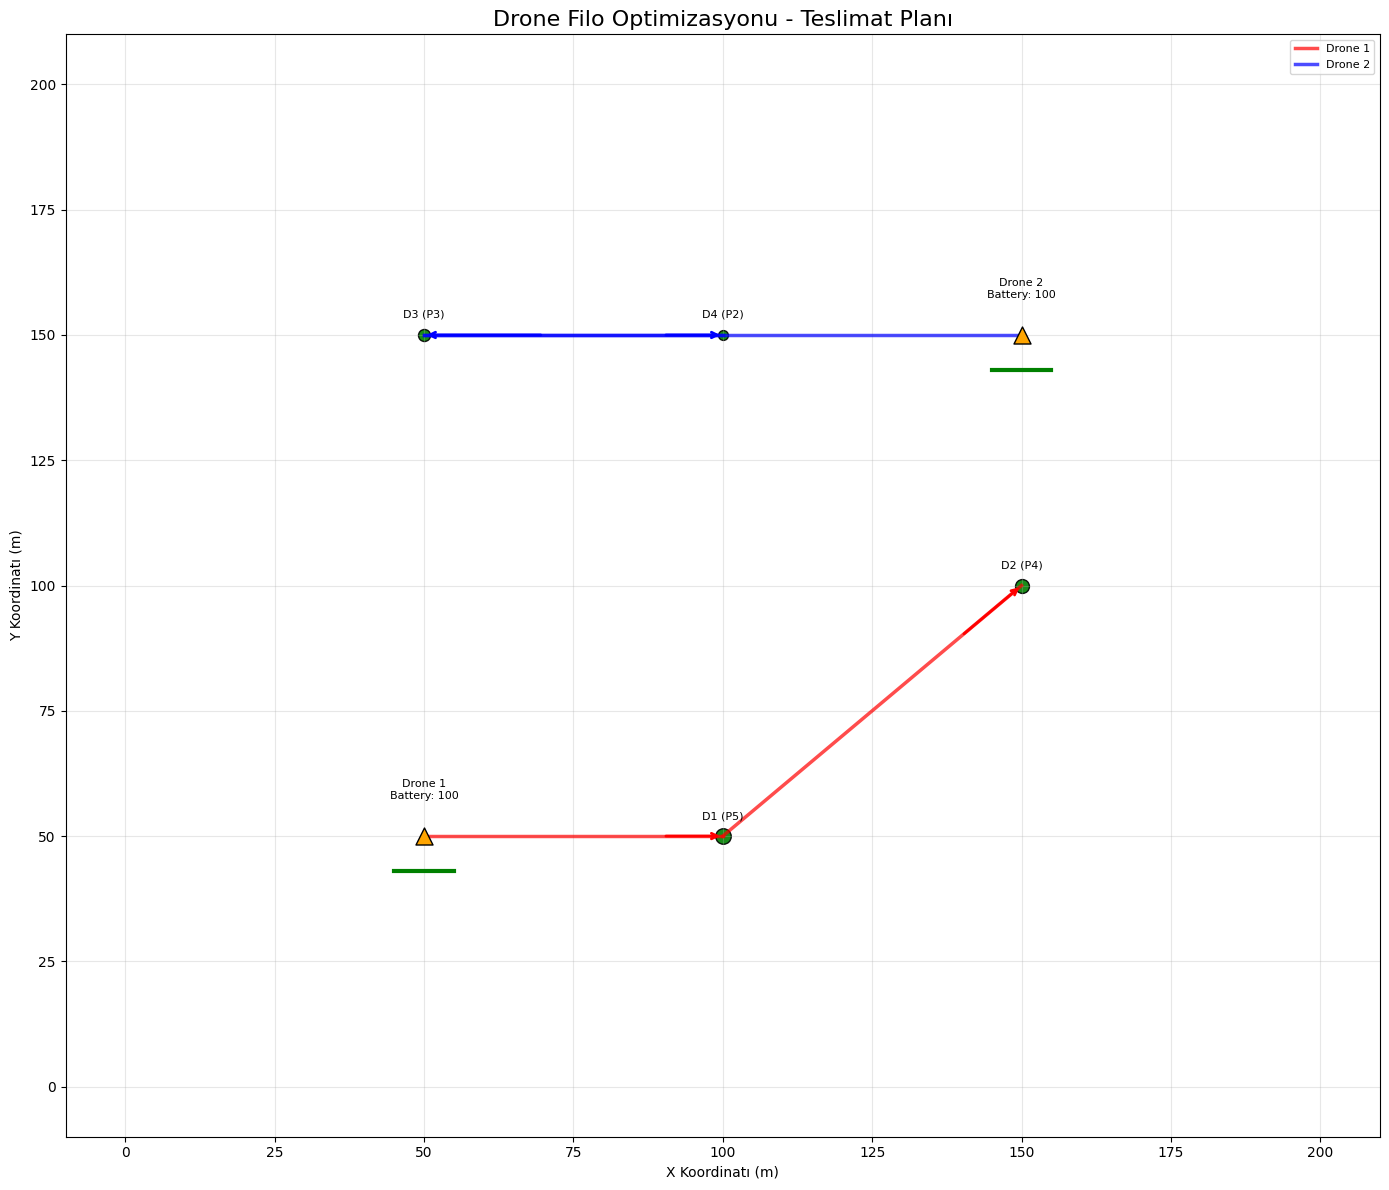

In [127]:
def test_simple_route_visualization():
    """Basit bir rota görselleştirme testi"""
    print("\n🧪 BASİT ROTA TESTİ BAŞLIYOR")

    # Test verileri oluştur
    class TestDrone:
        def __init__(self, id, pos):
            self.id = id
            self.current_pos = pos
            self.start_pos = pos
            self.remaining_battery = 100
            self.battery = 100

    class TestDelivery:
        def __init__(self, id, pos, priority=3):
            self.id = id
            self.pos = pos
            self.priority = priority

    # Test drone'ları
    test_drones = [
        TestDrone(1, (50, 50)),
        TestDrone(2, (150, 150))
    ]

    # Test teslimatları
    test_deliveries = [
        TestDelivery(1, (100, 50), 5),
        TestDelivery(2, (150, 100), 4),
        TestDelivery(3, (50, 150), 3),
        TestDelivery(4, (100, 150), 2)
    ]

    # Test rotaları
    test_routes = {
        1: [1, 2],  # Drone 1: Teslimat 1 ve 2
        2: [3, 4]   # Drone 2: Teslimat 3 ve 4
    }

    # Tamamlanan teslimatlar
    test_completed = {1, 2, 3, 4}

    # Görselleştir
    fig = visualize_drone_deliveries(
        drones=test_drones,
        deliveries=test_deliveries,
        no_fly_zones=None,
        completed_deliveries=test_completed,
        routes=test_routes,
        filename="test_simple_routes.png"
    )

    plt.show()
    print("✅ Basit rota testi tamamlandı!")

    return fig

# Önce basit testi çalıştır
test_simple_route_visualization()

In [128]:
def main_visualization_test():
    """Ana test fonksiyonu - rota görselleştirme"""
    print("\n📝 ROTA GÖRSELLEŞTIRME TESTİ\n")

    # Matplotlib backend'i ayarla (Colab için)
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    # 1. Basit test
    print("\n🔍 Test 1: Basit rota testi")
    test_simple_route_visualization()

    # 2. Gerçek simülasyon testi
    print("\n🔍 Test 2: Gerçek simülasyon ve rota oluşturma")
    simulation_results = test_simulation_and_routes()

    print("\n✅ TÜM TESTLER TAMAMLANDI")

    return simulation_results

In [129]:
import os

# Results klasörünü oluştur
if not os.path.exists('results'):
    os.makedirs('results')
    print("✅ 'results' klasörü oluşturuldu")

# Data klasörünü oluştur (eğer yoksa)
if not os.path.exists('data'):
    os.makedirs('data')
    print("✅ 'data' klasörü oluşturuldu")

In [130]:
def visualize_algorithm_comparison(scenario_name, drones, deliveries, no_fly_zones, astar_results, ga_results):
    """
    A* ve GA algoritmalarının karşılaştırmalı görselleştirmesi - ROTALARLA
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Öncelik renklerini tanımla
    priority_colors = {
        1: 'lightblue',
        2: 'skyblue',
        3: 'orange',
        4: 'darkorange',
        5: 'red'
    }

    # Drone'lara start_pos ekle
    for drone in drones:
        if not hasattr(drone, 'start_pos'):
            drone.start_pos = drone.current_pos

    # A* GÖRSELLEŞTIRME
    ax1.set_title(f"A* Algorithm - {len(astar_results['completed'])}/{len(deliveries)} Deliveries", fontsize=14)
    ax1.set_xlim(-10, 210)
    ax1.set_ylim(-10, 210)

    # No-fly zones
    for zone in no_fly_zones:
        polygon = patches.Polygon(zone.coordinates, closed=True, fill=True, alpha=0.3, color='red')
        ax1.add_patch(polygon)

    # Teslimat noktaları
    for delivery in deliveries:
        color = priority_colors.get(delivery.priority, 'gray')
        marker = 'o' if delivery.id in astar_results['completed'] else 'x'
        alpha = 1.0 if delivery.id in astar_results['completed'] else 0.5
        size = 50 + (delivery.priority * 20)

        ax1.scatter(delivery.pos[0], delivery.pos[1], s=size, c=color, marker=marker, alpha=alpha, edgecolors='black')
        ax1.text(delivery.pos[0], delivery.pos[1] + 3, f"{delivery.id}", fontsize=8)

    # Drone'lar
    for drone in drones:
        ax1.scatter(drone.start_pos[0], drone.start_pos[1], s=150, c='blue', marker='^', edgecolors='black', zorder=10)
        ax1.text(drone.start_pos[0], drone.start_pos[1] + 5, f"D{drone.id}", fontsize=9, fontweight='bold')

    # A* ROTALARI ÇİZ
    if 'routes' in astar_results and astar_results['routes']:
        colors = ['darkred', 'darkblue', 'darkgreen', 'purple', 'darkorange', 'brown', 'pink', 'gray', 'olive', 'cyan']

        for idx, (drone_id, delivery_ids) in enumerate(astar_results['routes'].items()):
            if not delivery_ids:
                continue

            # Drone'u bul
            drone = next((d for d in drones if d.id == drone_id), None)
            if not drone:
                continue

            route_color = colors[idx % len(colors)]
            current_pos = drone.start_pos

            # Her teslimat için çizgi çiz
            for delivery_id in delivery_ids:
                delivery = next((d for d in deliveries if d.id == delivery_id), None)
                if delivery:
                    ax1.plot([current_pos[0], delivery.pos[0]], [current_pos[1], delivery.pos[1]],
                            color=route_color, linewidth=2, alpha=0.7, linestyle='--',
                            label=f"Drone {drone_id}" if delivery_id == delivery_ids[0] else "")

                    # Ok ekle
                    dx = delivery.pos[0] - current_pos[0]
                    dy = delivery.pos[1] - current_pos[1]
                    if dx != 0 or dy != 0:
                        ax1.annotate('', xy=(delivery.pos[0], delivery.pos[1]),
                                   xytext=(current_pos[0] + 0.8*dx, current_pos[1] + 0.8*dy),
                                   arrowprops=dict(arrowstyle='->', color=route_color, lw=1.5))

                    current_pos = delivery.pos

    # GA GÖRSELLEŞTIRME
    ax2.set_title(f"Genetic Algorithm - {len(ga_results['completed'])}/{len(deliveries)} Deliveries", fontsize=14)
    ax2.set_xlim(-10, 210)
    ax2.set_ylim(-10, 210)

    # No-fly zones
    for zone in no_fly_zones:
        polygon = patches.Polygon(zone.coordinates, closed=True, fill=True, alpha=0.3, color='red')
        ax2.add_patch(polygon)

    # Teslimat noktaları
    for delivery in deliveries:
        color = priority_colors.get(delivery.priority, 'gray')
        marker = 'o' if delivery.id in ga_results['completed'] else 'x'
        alpha = 1.0 if delivery.id in ga_results['completed'] else 0.5
        size = 50 + (delivery.priority * 20)

        ax2.scatter(delivery.pos[0], delivery.pos[1], s=size, c=color, marker=marker, alpha=alpha, edgecolors='black')
        ax2.text(delivery.pos[0], delivery.pos[1] + 3, f"{delivery.id}", fontsize=8)

    # Drone'lar
    for drone in drones:
        ax2.scatter(drone.start_pos[0], drone.start_pos[1], s=150, c='blue', marker='^', edgecolors='black', zorder=10)
        ax2.text(drone.start_pos[0], drone.start_pos[1] + 5, f"D{drone.id}", fontsize=9, fontweight='bold')

    # GA ROTALARI ÇİZ
    if 'routes' in ga_results and ga_results['routes']:
        colors = ['darkred', 'darkblue', 'darkgreen', 'purple', 'darkorange', 'brown', 'pink', 'gray', 'olive', 'cyan']

        for idx, (drone_id, delivery_ids) in enumerate(ga_results['routes'].items()):
            if not delivery_ids:
                continue

            # Drone'u bul
            drone = next((d for d in drones if d.id == drone_id), None)
            if not drone:
                continue

            route_color = colors[idx % len(colors)]
            current_pos = drone.start_pos

            # Her teslimat için çizgi çiz
            for delivery_id in delivery_ids:
                delivery = next((d for d in deliveries if d.id == delivery_id), None)
                if delivery:
                    ax2.plot([current_pos[0], delivery.pos[0]], [current_pos[1], delivery.pos[1]],
                            color=route_color, linewidth=2, alpha=0.7, linestyle='-',
                            label=f"Drone {drone_id}" if delivery_id == delivery_ids[0] else "")

                    # Ok ekle
                    dx = delivery.pos[0] - current_pos[0]
                    dy = delivery.pos[1] - current_pos[1]
                    if dx != 0 or dy != 0:
                        ax2.annotate('', xy=(delivery.pos[0], delivery.pos[1]),
                                   xytext=(current_pos[0] + 0.8*dx, current_pos[1] + 0.8*dy),
                                   arrowprops=dict(arrowstyle='->', color=route_color, lw=1.5))

                    current_pos = delivery.pos

    # Grid ve etiketler
    for ax in [ax1, ax2]:
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("X Koordinatı (m)")
        ax.set_ylabel("Y Koordinatı (m)")

        # Lejant
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f"Öncelik {p}")
            for p, color in priority_colors.items()
        ]
        legend_elements.extend([
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label="Tamamlanan"),
            plt.Line2D([0], [0], marker='x', color='gray', markersize=8, label="Tamamlanmayan"),
            plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=8, label="Drone"),
            patches.Patch(color='red', alpha=0.3, label="No-Fly Zone")
        ])

        ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

    plt.suptitle(f"{scenario_name} - Algoritma Karşılaştırması", fontsize=16)
    plt.tight_layout()

    return fig

In [131]:
def visualize_performance_metrics(scenario_results):
    """
    Algoritma performans metriklerini görselleştiren fonksiyon
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Veri hazırla
    scenarios = [result['scenario'] for result in scenario_results]
    astar_times = [result['astar']['elapsed_time'] for result in scenario_results]
    ga_times = [result['ga']['elapsed_time'] for result in scenario_results]

    astar_completion = [result['astar']['completion_rate'] for result in scenario_results]
    ga_completion = [result['ga']['completion_rate'] for result in scenario_results]

    # Çalışma süresi grafiği
    x = range(len(scenarios))
    width = 0.35

    ax1.bar([i - width/2 for i in x], astar_times, width, label='A*', color='skyblue')
    ax1.bar([i + width/2 for i in x], ga_times, width, label='GA', color='orange')

    ax1.set_xlabel('Senaryo')
    ax1.set_ylabel('Çalışma Süresi (s)')
    ax1.set_title('Algoritma Çalışma Süreleri')
    ax1.set_xticks(x)
    ax1.set_xticklabels(scenarios)
    ax1.legend()

    # 1 dakika sınırını gösteren çizgi
    ax1.axhline(y=60, color='r', linestyle='--', alpha=0.7)
    ax1.text(len(scenarios) - 1, 62, '1 dakika sınırı', color='r')

    # Tamamlama oranı grafiği
    ax2.bar([i - width/2 for i in x], astar_completion, width, label='A*', color='skyblue')
    ax2.bar([i + width/2 for i in x], ga_completion, width, label='GA', color='orange')

    ax2.set_xlabel('Senaryo')
    ax2.set_ylabel('Tamamlama Oranı (%)')
    ax2.set_title('Teslimat Tamamlama Oranları')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenarios)
    ax2.legend()

    # Verimlilik skoru grafiği
    astar_efficiency = [(completion / max(time, 0.001)) * 10 for completion, time in zip(astar_completion, astar_times)]
    ga_efficiency = [(completion / max(time, 0.001)) * 10 for completion, time in zip(ga_completion, ga_times)]

    ax3.bar([i - width/2 for i in x], astar_efficiency, width, label='A*', color='skyblue')
    ax3.bar([i + width/2 for i in x], ga_efficiency, width, label='GA', color='orange')

    ax3.set_xlabel('Senaryo')
    ax3.set_ylabel('Verimlilik Skoru')
    ax3.set_title('Algoritma Verimliliği')
    ax3.set_xticks(x)
    ax3.set_xticklabels(scenarios)
    ax3.legend()

    plt.tight_layout()
    plt.suptitle('Algoritma Performans Karşılaştırması', fontsize=16, y=1.05)

    return fig

In [132]:
def run_full_benchmark_and_visualization():
    """
    Tam test, benchmark ve görselleştirme sürecini çalıştıran ana fonksiyon - ROTALARLA
    """
    print("🚀 DRONE FİLO OPTİMİZASYONU BENCHMARK BAŞLIYOR")
    print("=" * 80)

    # Tüm testlerin sonuçlarını tutacak liste
    all_results = []

    # Senaryo 1 testi
    print("\n📊 SENARYO 1 BAŞLIYOR: 5 drone, 20 teslimat, 2 no-fly zone")
    scenario1_results = test_scenario_1()
    all_results.append(scenario1_results)

    # Senaryo 1 için verileri yükle ve simülasyonları yeniden çalıştır
    drones1, deliveries1, zones1 = load_dataset("data/scenario1.txt")

    # Drone'lara start_pos ekle
    for drone in drones1:
        if not hasattr(drone, 'start_pos'):
            drone.start_pos = drone.current_pos

    # A* simülasyonu ve rota oluşturma
    astar_completed_1, astar_duration_1, astar_logs_1 = simulate_astar_day_all_drones(
        deliveries1.copy(), drones1.copy(), zones1
    )
    astar_routes_1 = create_route_map_from_logs(astar_logs_1, astar_completed_1)

    # GA simülasyonu ve rota oluşturma
    ga_completed_1, ga_duration_1, ga_logs_1 = simulate_ga_day_all_drones(
        deliveries1.copy(), drones1.copy(), zones1
    )
    ga_routes_1 = create_route_map_from_logs(ga_logs_1, ga_completed_1)

    # Senaryo 2 testi
    print("\n📊 SENARYO 2 BAŞLIYOR: 10 drone, 50 teslimat, 5 no-fly zone")
    scenario2_results = test_scenario_2()
    all_results.append(scenario2_results)

    # Senaryo 2 için verileri yükle ve simülasyonları yeniden çalıştır
    drones2, deliveries2, zones2 = load_dataset("data/scenario2.txt")

    # Drone'lara start_pos ekle
    for drone in drones2:
        if not hasattr(drone, 'start_pos'):
            drone.start_pos = drone.current_pos

    # A* simülasyonu ve rota oluşturma
    astar_completed_2, astar_duration_2, astar_logs_2 = simulate_astar_day_all_drones(
        deliveries2.copy(), drones2.copy(), zones2
    )
    astar_routes_2 = create_route_map_from_logs(astar_logs_2, astar_completed_2)

    # GA simülasyonu ve rota oluşturma
    ga_completed_2, ga_duration_2, ga_logs_2 = simulate_ga_day_all_drones(
        deliveries2.copy(), drones2.copy(), zones2
    )
    ga_routes_2 = create_route_map_from_logs(ga_logs_2, ga_completed_2)

    # Performans grafikleri
    print("\n📈 PERFORMANS GRAFİKLERİ OLUŞTURULUYOR")
    perf_fig = visualize_performance_metrics(all_results)
    perf_fig.savefig("results/performance_comparison.png", dpi=300, bbox_inches='tight')

    # Algoritma karşılaştırma görselleştirmeleri
    print("\n🎨 ALGORİTMA KARŞILAŞTIRMA GÖRSELLERİ OLUŞTURULUYOR")

    # Senaryo 1 görselleştirme - ROTALARLA
    scenario1_fig = visualize_algorithm_comparison(
        "Senaryo 1",
        drones1,
        deliveries1,
        zones1,
        {
            'completed': astar_completed_1,
            'routes': astar_routes_1  # Rotaları ekle
        },
        {
            'completed': ga_completed_1,
            'routes': ga_routes_1  # Rotaları ekle
        }
    )
    scenario1_fig.savefig("results/scenario1_comparison.png", dpi=300, bbox_inches='tight')
    print("✅ Senaryo 1 görselleştirme kaydedildi: results/scenario1_comparison.png")

    # Senaryo 2 görselleştirme - ROTALARLA
    scenario2_fig = visualize_algorithm_comparison(
        "Senaryo 2",
        drones2,
        deliveries2,
        zones2,
        {
            'completed': astar_completed_2,
            'routes': astar_routes_2  # Rotaları ekle
        },
        {
            'completed': ga_completed_2,
            'routes': ga_routes_2  # Rotaları ekle
        }
    )
    scenario2_fig.savefig("results/scenario2_comparison.png", dpi=300, bbox_inches='tight')
    print("✅ Senaryo 2 görselleştirme kaydedildi: results/scenario2_comparison.png")

    # Detaylı performans benchmark
    print("\n⚡ DETAYLI PERFORMANS BENCHMARK BAŞLIYOR")
    benchmark_results = run_performance_benchmark(num_drones=10, num_deliveries=50, num_zones=5, repetitions=3)

    print("\n🏁 BENCHMARK TAMAMLANDI")
    print("=" * 80)

    # Tüm sonuçları döndür
    return {
        'scenario1': scenario1_results,
        'scenario2': scenario2_results,
        'benchmark': benchmark_results,
        'visualizations': {
            'scenario1_routes': {'astar': astar_routes_1, 'ga': ga_routes_1},
            'scenario2_routes': {'astar': astar_routes_2, 'ga': ga_routes_2}
        }
    }

In [133]:
def analyze_time_complexity():
    """
    A* ve GA algoritmalarının zaman karmaşıklığı analizi
    """
    print("\n⏱️ ZAMAN KARMAŞIKLIĞI ANALİZİ")
    print("=" * 80)

    # Test edilecek boyutlar
    sizes = [10, 20, 30, 40, 50, 60]

    # Sonuçları tutacak listeler
    astar_times = []
    ga_times = []

    for size in sizes:
        print(f"\nTest boyutu: {size} teslimat")

        # Veri oluştur
        test_drones_data = generate_drones(size // 5)  # Her 5 teslimat için 1 drone
        test_deliveries_data = generate_deliveries(size)
        test_zones_data = generate_no_fly_zones(size // 10)  # Her 10 teslimat için 1 zone

        # Verileri geçici olarak kaydet ve yükle
        temp_file = f"data/complexity_temp_{size}.txt"
        save_dataset_to_txt(test_drones_data, test_deliveries_data, test_zones_data, temp_file)

        # Nesneleri yükle
        test_drones, test_deliveries, test_zones = load_dataset(temp_file)

        # A* testi
        start_time = time.time()
        astar_completed, _, _ = simulate_astar_day_all_drones(
            test_deliveries, test_drones, test_zones,
            start_time=dt_time(10, 0), end_time=dt_time(12, 0)  # Kısa simülasyon süresi
        )
        astar_elapsed = time.time() - start_time
        astar_times.append(astar_elapsed)

        print(f"A* Algoritması: {astar_elapsed:.2f} saniye ({len(astar_completed)}/{size} teslimat)")

        # GA testi
        start_time = time.time()
        ga_completed, _, _ = simulate_ga_day_all_drones(
            test_deliveries, test_drones, test_zones,
            start_time=dt_time(10, 0), end_time=dt_time(12, 0)  # Kısa simülasyon süresi
        )
        ga_elapsed = time.time() - start_time
        ga_times.append(ga_elapsed)

        print(f"GA Algoritması: {ga_elapsed:.2f} saniye ({len(ga_completed)}/{size} teslimat)")

    # Zaman karmaşıklığı analizi grafiği
    plt.figure(figsize=(10, 6))

    plt.plot(sizes, astar_times, 'o-', label='A* Algoritması', color='skyblue')
    plt.plot(sizes, ga_times, 'o-', label='GA Algoritması', color='orange')

    # Trend çizgileri
    from scipy.optimize import curve_fit

    def polynomial(x, a, b, c):
        """Polinom fonksiyonu: a*x^2 + b*x + c"""
        return a * np.array(x) ** 2 + b * np.array(x) + c

    # A* için trend çizgisi (O(n^2) beklenir)
    popt_astar, _ = curve_fit(polynomial, sizes, astar_times)
    x_smooth = np.linspace(min(sizes), max(sizes), 100)
    y_smooth_astar = polynomial(x_smooth, *popt_astar)
    plt.plot(x_smooth, y_smooth_astar, '--', color='blue',
             label=f'A* Trend: {popt_astar[0]:.4f}x² + {popt_astar[1]:.4f}x + {popt_astar[2]:.4f}')

    # GA için trend çizgisi (O(n*log(n)) veya O(n^2) beklenir)
    popt_ga, _ = curve_fit(polynomial, sizes, ga_times)
    y_smooth_ga = polynomial(x_smooth, *popt_ga)
    plt.plot(x_smooth, y_smooth_ga, '--', color='red',
             label=f'GA Trend: {popt_ga[0]:.4f}x² + {popt_ga[1]:.4f}x + {popt_ga[2]:.4f}')

    plt.xlabel('Teslimat Sayısı (n)')
    plt.ylabel('Çalışma Süresi (s)')
    plt.title('Algoritma Zaman Karmaşıklığı Analizi')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 1 dakika sınırını gösteren çizgi
    plt.axhline(y=60, color='r', linestyle='--', alpha=0.7)
    plt.text(sizes[-1], 62, '1 dakika sınırı', color='r')

    plt.tight_layout()
    plt.savefig("results/time_complexity_analysis.png", dpi=300, bbox_inches='tight')

    # Zaman karmaşıklığı sonuçlarını yazdır
    print("\n📊 ZAMAN KARMAŞIKLIĞI ANALİZ SONUÇLARI:")
    print(f"A* Algoritması: ~O(n²) - Katsayı: {popt_astar[0]:.6f}")
    print(f"GA Algoritması: ~O(n²) - Katsayı: {popt_ga[0]:.6f}")

    # Büyüme oranları
    astar_growth = [astar_times[i]/astar_times[i-1] for i in range(1, len(astar_times))]
    ga_growth = [ga_times[i]/ga_times[i-1] for i in range(1, len(ga_times))]

    size_ratios = [sizes[i]/sizes[i-1] for i in range(1, len(sizes))]

    print("\nBüyüme Oranları:")
    for i in range(len(astar_growth)):
        print(f"Boyut {sizes[i]} → {sizes[i+1]} (x{size_ratios[i]:.2f}):")
        print(f"  A* Büyüme: x{astar_growth[i]:.2f}")
        print(f"  GA Büyüme: x{ga_growth[i]:.2f}")

    return {
        'sizes': sizes,
        'astar_times': astar_times,
        'ga_times': ga_times,
        'astar_complexity': {
            'coefficients': popt_astar,
            'estimated_order': 'O(n²)'
        },
        'ga_complexity': {
            'coefficients': popt_ga,
            'estimated_order': 'O(n²)'
        }
    }

In [134]:
# Test ve benchmark senaryolarını çalıştır
if __name__ == "__main__":
    print("=" * 80)
    print("🚀 DRONE FİLO OPTİMİZASYONU TEST VE BENCHMARK BAŞLIYOR")
    print("=" * 80)

    # Tüm testleri çalıştır
    all_results = run_full_benchmark_and_visualization()

    # Zaman karmaşıklığı analizi
    complexity_results = analyze_time_complexity()

    print("\n✅ TÜM TESTLER TAMAMLANDI!")
    print("=" * 80)

    # Özet sonuçları yazdır
    print("\n📋 ÖZET SONUÇLAR:")

    # Senaryo 1 sonuçları
    print("\nSenaryo 1 (5 drone, 20 teslimat, 2 no-fly zone):")
    s1 = all_results['scenario1']
    print(f"A* Algoritması: {s1['astar']['completed']}/{s1['deliveries']} teslimat, {s1['astar']['elapsed_time']:.2f} saniye")
    print(f"GA Algoritması: {s1['ga']['completed']}/{s1['deliveries']} teslimat, {s1['ga']['elapsed_time']:.2f} saniye")

    # Senaryo 2 sonuçları
    print("\nSenaryo 2 (10 drone, 50 teslimat, 5 no-fly zone):")
    s2 = all_results['scenario2']
    print(f"A* Algoritması: {s2['astar']['completed']}/{s2['deliveries']} teslimat, {s2['astar']['elapsed_time']:.2f} saniye")
    print(f"GA Algoritması: {s2['ga']['completed']}/{s2['deliveries']} teslimat, {s2['ga']['elapsed_time']:.2f} saniye")

    # Performans benchmark sonuçları
    print("\nPerformans Benchmark (50+ teslimat için <1 dakika kriteri):")
    bench = all_results['benchmark']
    print(f"A* Ortalama Süre: {bench['astar']['avg_time']:.2f} saniye - {'✅ BAŞARILI' if bench['astar']['passed_criteria'] else '❌ BAŞARISIZ'}")
    print(f"GA Ortalama Süre: {bench['ga']['avg_time']:.2f} saniye - {'✅ BAŞARILI' if bench['ga']['passed_criteria'] else '❌ BAŞARISIZ'}")

    # Zaman karmaşıklığı sonuçları
    print("\nZaman Karmaşıklığı Analizi:")
    print(f"A* Algoritması: {complexity_results['astar_complexity']['estimated_order']}")
    print(f"GA Algoritması: {complexity_results['ga_complexity']['estimated_order']}")

    print("\n🎉 DRONE FİLO OPTİMİZASYONU PROJESİ TAMAMLANDI!")
    print("=" * 80)

🚀 DRONE FİLO OPTİMİZASYONU TEST VE BENCHMARK BAŞLIYOR
🚀 DRONE FİLO OPTİMİZASYONU BENCHMARK BAŞLIYOR

📊 SENARYO 1 BAŞLIYOR: 5 drone, 20 teslimat, 2 no-fly zone
🧬 GA optimizasyonu ilk kez başlatılıyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Gen   0: Best=-1968.00, Avg=-2654.51, Deliveries=20
Gen  10: Best=-919.00, Avg=-1142.02, Deliveries=20
Gen  20: Best=-919.00, Avg=-946.90, Deliveries=20
Gen  30: Best=-919.00, Avg=-950.75, Deliveries=20
🎯 Early stopping: 30 nesil boyunca anlamlı iyileşme yok - Gen 38
✅ GA Tamamlandı! En iyi fitness: -919.00
📦 Tamamlanan teslimat: 20/20
📈 Başarı oranı: %100.0
🔄 GA çözüm bulamadı (Deneme 1/2). Farklı parametrelerle tekrar deneniyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Gen   0: Best=-1897.00, Avg=-2653.42, Deliveries=20
Gen  10: Best=-1490.00, Avg=-2005.65, Deliveries=20
Gen  20: Best=-1393.00, Avg=-1555.39, Del

<ipython-input-130-06164f56429c>:38: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(delivery.pos[0], delivery.pos[1], s=size, c=color, marker=marker, alpha=alpha, edgecolors='black')
<ipython-input-130-06164f56429c>:97: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(delivery.pos[0], delivery.pos[1], s=size, c=color, marker=marker, alpha=alpha, edgecolors='black')


✅ Senaryo 1 görselleştirme kaydedildi: results/scenario1_comparison.png
✅ Senaryo 2 görselleştirme kaydedildi: results/scenario2_comparison.png

⚡ DETAYLI PERFORMANS BENCHMARK BAŞLIYOR

🔬 PERFORMANS BENCHMARK BAŞLIYOR (Drone: 10, Teslimat: 50, NFZ: 5)

Tekrar 1/3:
A* Algoritması: 3.18 saniye, 37/50 teslimat
🧬 GA optimizasyonu ilk kez başlatılıyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Gen   0: Best=-5867.00, Avg=-6972.24, Deliveries=50
Gen  10: Best=-5063.00, Avg=-5392.69, Deliveries=50
Gen  20: Best=-4367.00, Avg=-4508.44, Deliveries=50
Gen  30: Best=-4274.00, Avg=-4505.69, Deliveries=50
Gen  40: Best=-3952.00, Avg=-4381.05, Deliveries=50
✅ GA Tamamlandı! En iyi fitness: -3853.00
📦 Tamamlanan teslimat: 50/50
📈 Başarı oranı: %100.0
🔄 GA çözüm bulamadı (Deneme 1/2). Farklı parametrelerle tekrar deneniyor...
🧬 GA optimizasyonu başlatılıyor...
🧬 Genetik Algoritma Başlıyor...
📊 Parametreler: pop=100, gen=50, mut=0.2
Ge